# Research goal: Analyze diamonds by their cut, color, clarity, price, and other attributes.

In [57]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from scipy import stats
from scipy.stats import norm
import statistics
import statsmodels.api as sm
import pylab as py

import plotly.express as px

pd.set_option('display.float_format', lambda x: '%.3f' % x)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn. linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [2]:
df = pd.read_csv("/content/diamonds.csv")
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.230,Ideal,E,SI2,61.500,55.000,326,3.950,3.980,2.430
1,2,0.210,Premium,E,SI1,59.800,61.000,326,3.890,3.840,2.310
2,3,0.230,Good,E,VS1,56.900,65.000,327,4.050,4.070,2.310
3,4,0.290,Premium,I,VS2,62.400,58.000,334,4.200,4.230,2.630
4,5,0.310,Good,J,SI2,63.300,58.000,335,4.340,4.350,2.750


# Understanding the features:

* The dataset contains the prices and other attributes of nearly 54,000 diamonds. There are 10 attributes

* Feature description:

* price: It ranges from $18,823 and $326.This is our outcome or dependent variable (target variable)--> y

* cut : It is related to physical attribute of diamonds and it is a categorical and ordinal variable.We can think that it is related to quality. --> Fair < Good < Very Good < Premium < Ideal

* color : J (worst) to D (best) - it is a categorical and ordinal variable

* carat : The carat is related to the diamond’s physical weight. It ranges from 0.2 and 5.01.

* clarity : I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best) --> it is a categorical and ordinal variable.

* Dimensions -> x,y,z

* x : length in mm (0--10.74)
* y : width in mm (0--58.9)
* z : depth in mm (0--31.8)

* depth : total depth percentage = z / mean(x, y) = 2 * z / (x + y) --> it ranges from (43--79)

* table : width of top of diamond relative to widest point (43--95) -> continious varible

![pic](https://gcdnb.pbrd.co/images/2PRTin9PrjbR.jpg?o=1)

**Dictionary of the 3 categorical features:**

| feature name | order | values |
| --- |: --- :| --- |
| Diamond cut quality | ascending  | {Fair, Good, Very Good, Premium, Ideal} |
| diamond color | descending | {D , E , F , G , H , I , J} |
| Diamond Clarity | ascending | {I1 , SI2 , SI1 , VS2 , VS1 , VVS2 , VVS1 , IF} |

## Basic Data Exploration

In [3]:
df = df.drop(columns = "Unnamed: 0")
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.230,Ideal,E,SI2,61.500,55.000,326,3.950,3.980,2.430
1,0.210,Premium,E,SI1,59.800,61.000,326,3.890,3.840,2.310
2,0.230,Good,E,VS1,56.900,65.000,327,4.050,4.070,2.310
3,0.290,Premium,I,VS2,62.400,58.000,334,4.200,4.230,2.630
4,0.310,Good,J,SI2,63.300,58.000,335,4.340,4.350,2.750


In [4]:
df.shape

(53940, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [6]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000,53940.000,53940.000,53940.000,53940.000,53940.000,53940.000
mean,0.798,61.749,57.457,3932.800,5.731,5.735,3.539
std,0.474,1.433,2.234,3989.440,1.122,1.142,0.706
min,0.200,43.000,43.000,326.000,0.000,0.000,0.000
25%,0.400,61.000,56.000,950.000,4.710,4.720,2.910
50%,0.700,61.800,57.000,2401.000,5.700,5.710,3.530
75%,1.040,62.500,59.000,5324.250,6.540,6.540,4.040
max,5.010,79.000,95.000,18823.000,10.740,58.900,31.800


In [7]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [8]:
df = df.drop_duplicates()

## Outlier Analysis Function

In [9]:
#Tukey's method
def tukeys_method(df, variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr

    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence

    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence

    outliers_prob = []
    outliers_poss = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob.append(index)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)
    return outliers_prob, outliers_poss

## Hypothesis Testing Function

In [10]:
def hypotesis_testing(data, value, variable):
    frame=data[[variable, value]]
    formula=f'{value} ~ {variable}'
    model=ols(formula, frame).fit()
    print(model.summary(), "\n", "#"*50)

    p_value=np.round(model.f_pvalue, 3)
    print("p_value:", p_value)

    if p_value<0.05:
        print("Reject Null Hypothesis and accept the alternate hypothesis")
    else:
        print("Accept the Null Hypothesis")

## Data Analysis

In [11]:
df.describe(include = "number")

,carat,depth,table,price,x,y,z
count,53794.000,53794.000,53794.000,53794.000,53794.000,53794.000,53794.000
mean,0.798,61.748,57.458,3933.065,5.731,5.735,3.539
std,0.473,1.430,2.234,3988.114,1.121,1.141,0.705
min,0.200,43.000,43.000,326.000,0.000,0.000,0.000
25%,0.400,61.000,56.000,951.000,4.710,4.720,2.910
50%,0.700,61.800,57.000,2401.000,5.700,5.710,3.530
75%,1.040,62.500,59.000,5326.750,6.540,6.540,4.030
max,5.010,79.000,95.000,18823.000,10.740,58.900,31.800


In [12]:
df.describe(include = "object")

,cut,color,clarity
count,53794,53794,53794
unique,5,7,8
top,Ideal,G,SI1
freq,21488,11262,13032


In [13]:
df_quant = df[["carat", "depth", "table", "price", "x", "y", "z"]]
df_quant.head()

,carat,depth,table,price,x,y,z
0,0.230,61.500,55.000,326,3.950,3.980,2.430
1,0.210,59.800,61.000,326,3.890,3.840,2.310
2,0.230,56.900,65.000,327,4.050,4.070,2.310
3,0.290,62.400,58.000,334,4.200,4.230,2.630
4,0.310,63.300,58.000,335,4.340,4.350,2.750


In [14]:
df_qual = df[["cut", "color", "clarity"]]
df_qual.head()

,cut,color,clarity
0,Ideal,E,SI2
1,Premium,E,SI1
2,Good,E,VS1
3,Premium,I,VS2
4,Good,J,SI2


In [15]:
for col in ['color','cut', 'clarity']:
    print(df_qual[col].value_counts())
    print('='*30)

G    11262
E     9776
F     9520
H     8272
D     6755
I     5407
J     2802
Name: color, dtype: int64
Ideal        21488
Premium      13748
Very Good    12069
Good          4891
Fair          1598
Name: cut, dtype: int64
SI1     13032
VS2     12229
SI2      9150
VS1      8156
VVS2     5056
VVS1     3647
IF       1784
I1        740
Name: clarity, dtype: int64


## Handling Outliers

In [16]:
for col in df_quant.columns:
  print(col, tukeys_method(df_quant, col))

carat ([16245, 19298, 19305, 21713, 21816, 22378, 22490, 22691, 22780, 23486, 23591, 24076, 24241, 24272, 24760, 25402, 25792, 25939, 25940, 26040, 26370, 26383, 26406, 26473, 26681, 26869, 26870, 27065, 27350, 27449, 27450, 27451, 27563, 27571, 27582, 27612, 27617, 27618], [11606, 12218, 12971, 13087, 13726, 13897, 13959, 13960, 14105, 14612, 14879, 14880, 15116, 15283, 15647, 15744, 15778, 15824, 15828, 15829, 15868, 15903, 15904, 16219, 16245, 16260, 16289, 16303, 16401, 16458, 16466, 16467, 16599, 16747, 16877, 16986, 17059, 17126, 17142, 17157, 17427, 17442, 17447, 17450, 17520, 17651, 17819, 17857, 17916, 17920, 18027, 18191, 18233, 18419, 18977, 19040, 19142, 19176, 19290, 19298, 19305, 19365, 19417, 19418, 19557, 19600, 19806, 19824, 19852, 19879, 19904, 20157, 20251, 20255, 20295, 20385, 20420, 20510, 20616, 20762, 20795, 20808, 20817, 20834, 20934, 21094, 21236, 21237, 21286, 21294, 21404, 21469, 21505, 21508, 21509, 21510, 21522, 21580, 21585, 21586, 21588, 21632, 21675, 216

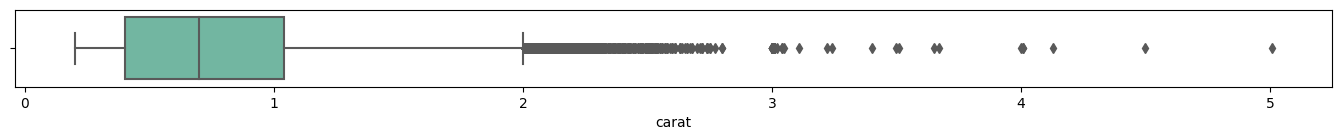

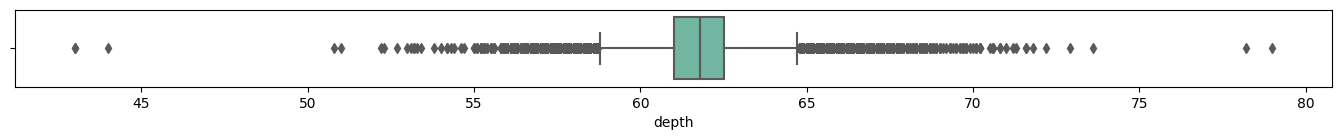

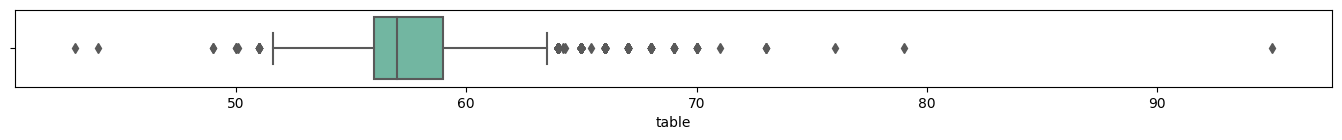

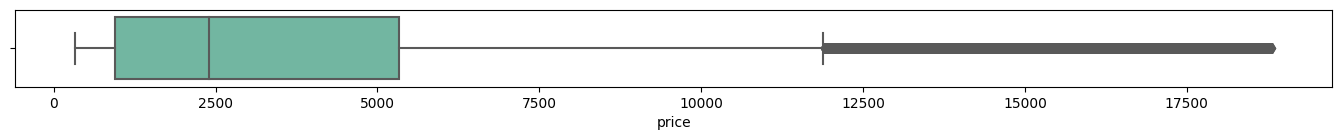

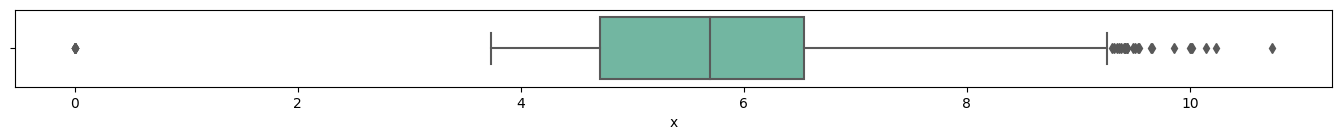

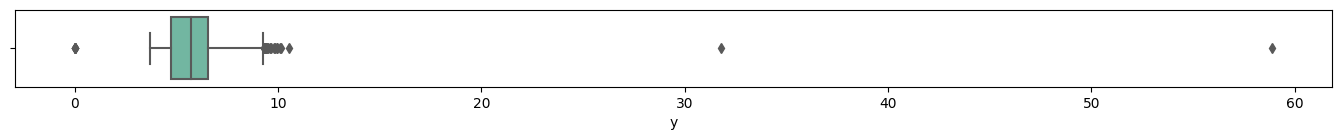

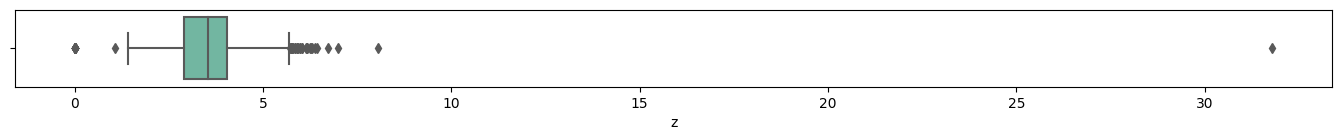

In [17]:
for column in df_quant:
        plt.figure(figsize=(17,1))
        sns.boxplot(data=df_quant, orient="h", palette="Set2", x=column)

In [18]:
for col in df_quant.columns:
  q1 = df_quant[col].quantile(0.25)
  q3 = df_quant[col].quantile(0.75)
  iqr = q3 - q1
  whisker_width = 1.5
  lower_whisker = q1 - (whisker_width * iqr)
  upper_whisker = q3 + whisker_width * iqr
  df_quant[col] = np.where(df_quant[col] > upper_whisker, upper_whisker, np.where(df_quant[col] < lower_whisker, lower_whisker, df_quant[col]))

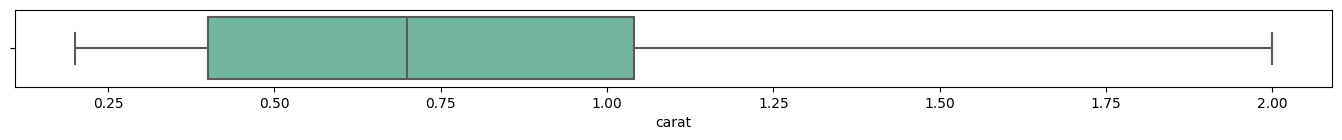

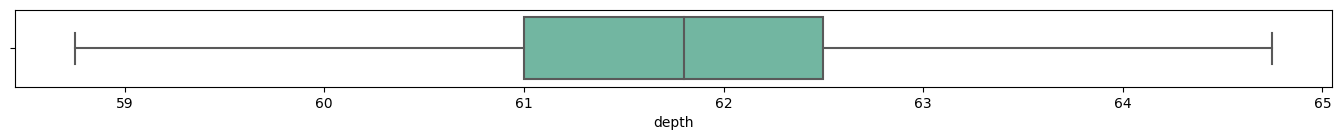

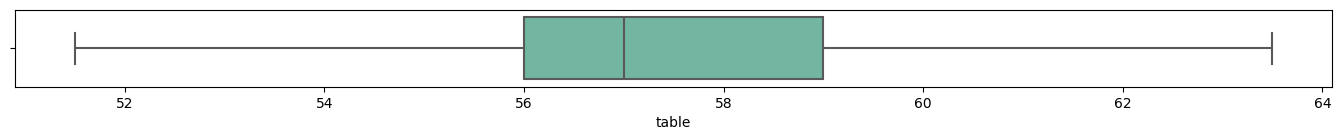

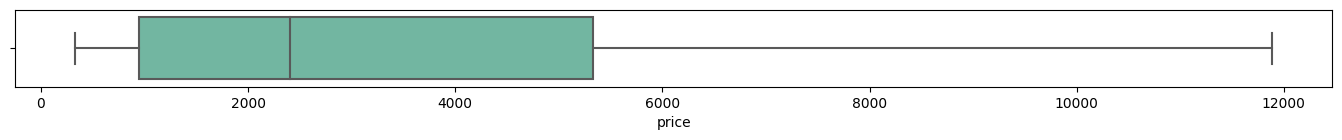

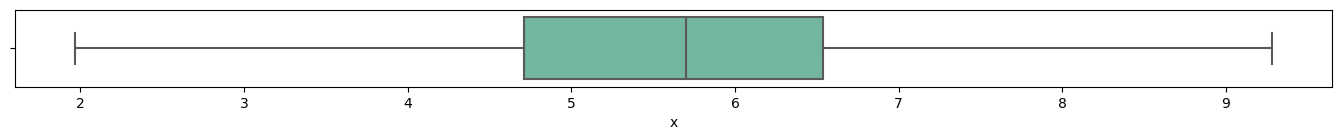

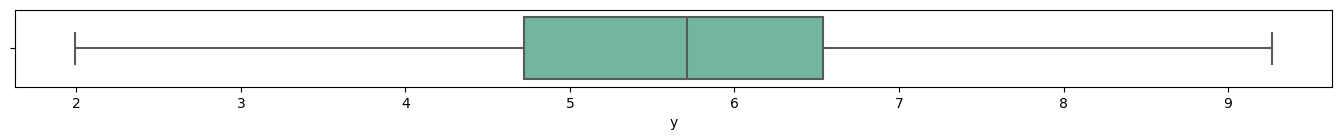

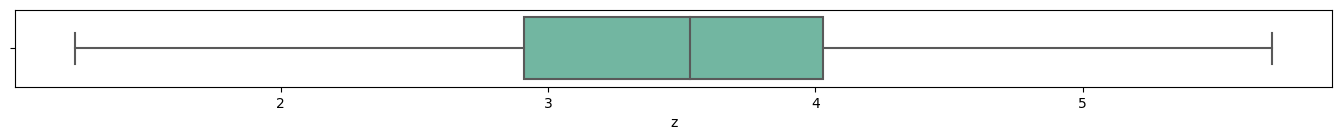

In [19]:
for column in df_quant:
        plt.figure(figsize=(17,1))
        sns.boxplot(data=df_quant, orient="h", palette="Set2", x=column)

In [20]:
df_quant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53794 entries, 0 to 53939
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   carat   53794 non-null  float64
 1   depth   53794 non-null  float64
 2   table   53794 non-null  float64
 3   price   53794 non-null  float64
 4   x       53794 non-null  float64
 5   y       53794 non-null  float64
 6   z       53794 non-null  float64
dtypes: float64(7)
memory usage: 3.3 MB


### Exploratory Data Analysis

#### Custom Palette for Visualization

In [21]:
sns.set_style("white")
sns.set(rc={"axes.facecolor":"#f2d4b1","figure.facecolor":"#f2d4b1","grid.color":"white"})
sns.set_context("poster",font_scale = .7)

palette = ["#c94727","#ea5b17","#e57716","#f2a324","#a2c0a6","#7ac0a8","#5e9786","#557260"]

# sns.palplot(sns.color_palette(palette))
# plt.show()

Let's have a look on the distribution of prices :


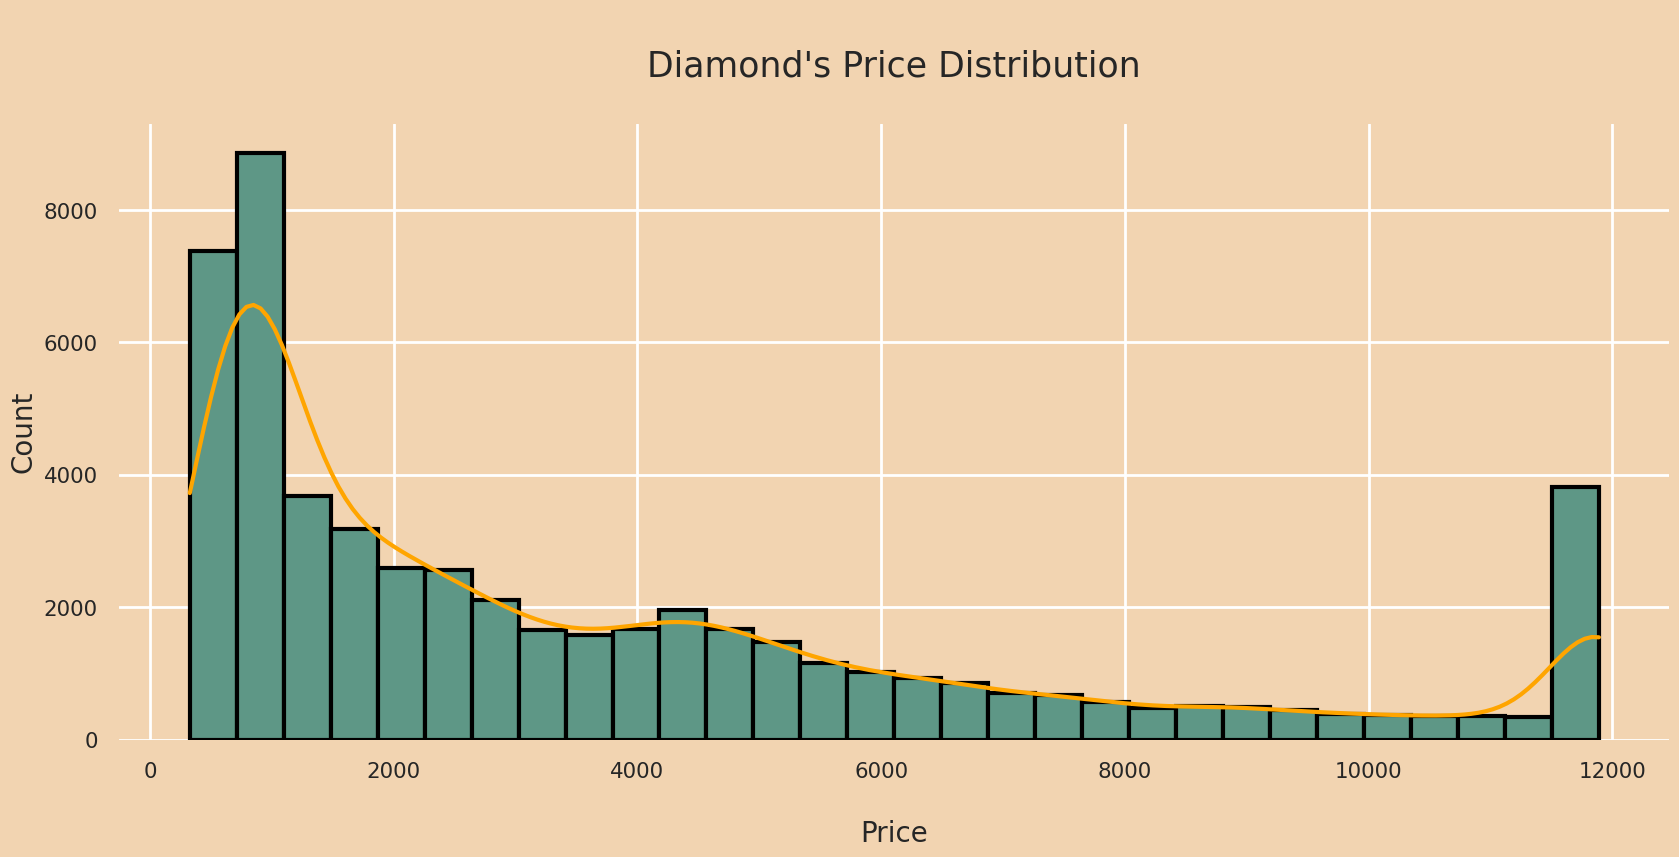

In [22]:
print(f"Let's have a look on the distribution of prices :")
plt.subplots(figsize=(20, 8))
p = sns.histplot(df_quant["price"],color=palette[6],kde=True,bins=30,alpha=1,fill=True,edgecolor="black",linewidth=3)
p.axes.lines[0].set_color("orange")
p.axes.set_title("\nDiamond's Price Distribution\n",fontsize=25)
plt.ylabel("Count",fontsize=20)
plt.xlabel("\nPrice",fontsize=20)
plt.yscale("linear")
sns.despine(left=True, bottom=True)

plt.show()

Let's have a look on the ratio of diamond's cut :


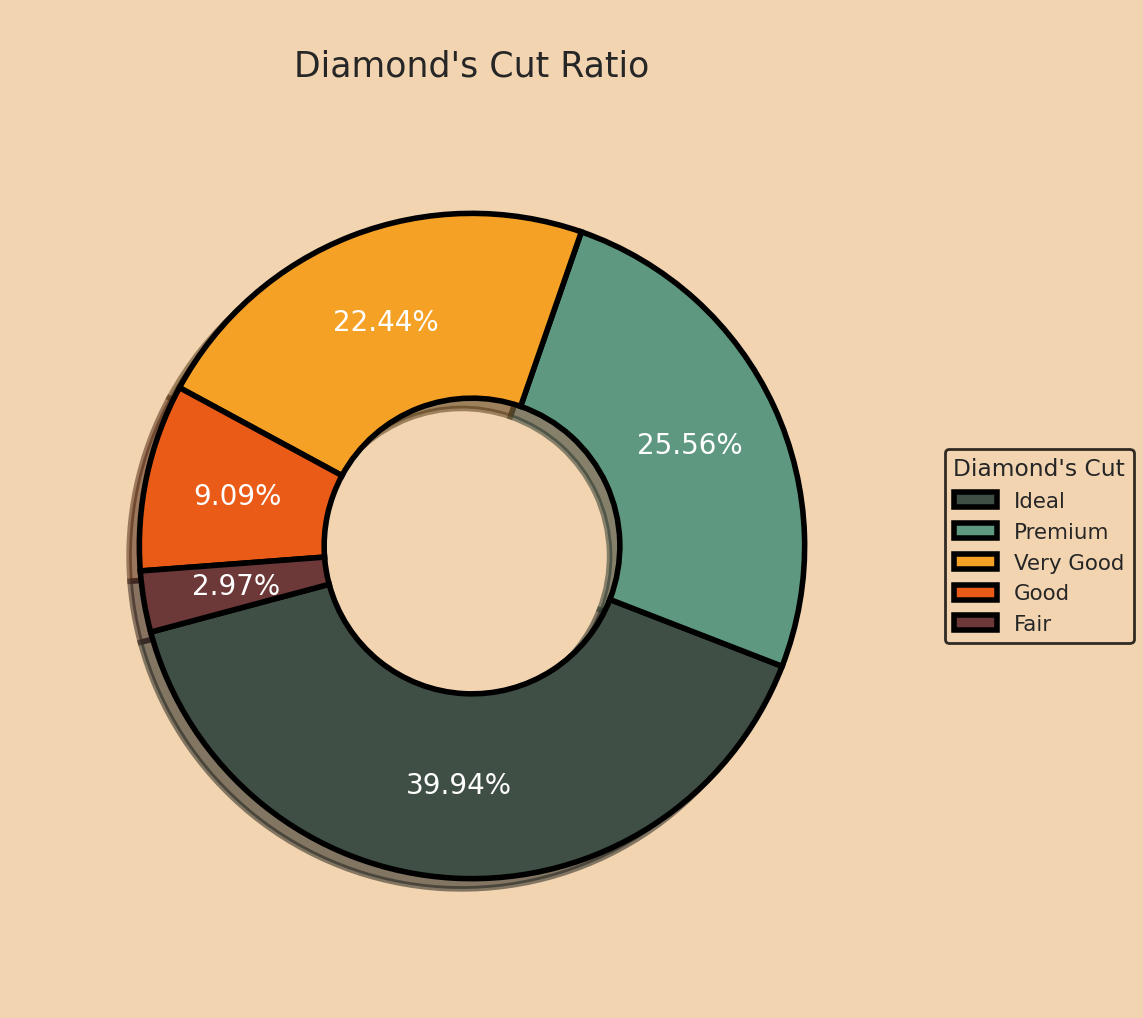

In [23]:
print(f"Let's have a look on the ratio of diamond's cut :")
plt.subplots(figsize=(12, 12))

labels = "Ideal","Premium","Very Good","Good","Fair"
size = 0.5

wedges, texts, autotexts = plt.pie([df_qual["cut"].value_counts().values[0],
                                    df_qual["cut"].value_counts().values[1],
                                    df_qual["cut"].value_counts().values[2],
                                    df_qual["cut"].value_counts().values[3],
                                    df_qual["cut"].value_counts().values[4]],
                                    explode = (0,0,0,0,0),
                                    textprops=dict(size= 20, color= "white"),
                                    autopct="%.2f%%",
                                    pctdistance = 0.72,
                                    radius=.9,
                                    colors = ["#3f4f45","#5e9880","#f5a126","#ea5b17","#6c3938"],
                                    shadow = True,
                                    wedgeprops=dict(width = size, edgecolor = "black",
                                    linewidth = 4),
                                    startangle = -165)

plt.legend(wedges, labels, title="Diamond's Cut",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1), edgecolor = "black")
plt.title("\nDiamond's Cut Ratio",fontsize=25)
plt.show()

Let's have a look on the diamond's cut :


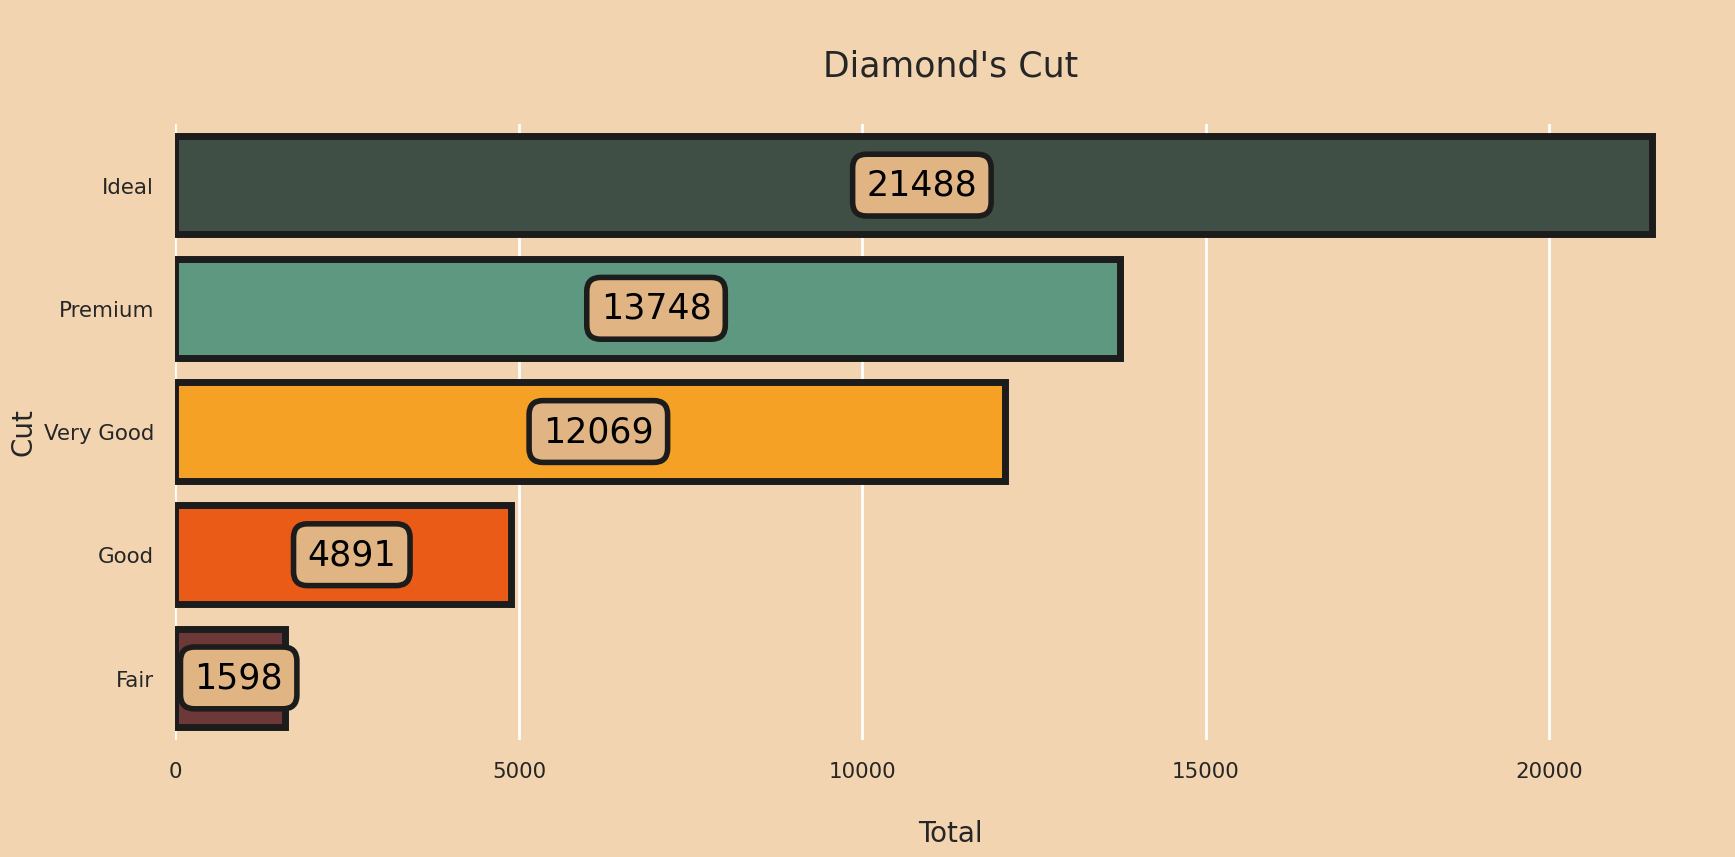

In [24]:
print("Let's have a look on the diamond's cut :")
plt.subplots(figsize=(20, 8))
p=sns.countplot(y=df_qual["cut"],order=df_qual["cut"].value_counts().index,palette=["#3f4f45","#5e9880","#f5a126","#ea5b17","#6c3938"], saturation=1, edgecolor = "#1c1c1c", linewidth = 5)
# p.axes.set_yscale("symlog")
p.axes.set_title("\nDiamond's Cut\n",fontsize=25)
p.axes.set_ylabel("Cut",fontsize=20)
p.axes.set_xlabel("\nTotal",fontsize=20)
p.axes.set_yticklabels(p.get_yticklabels(),rotation = 0)
for container in p.containers:
    p.bar_label(container,label_type="center",padding=6,size=25,color="black",rotation=0,
    bbox={"boxstyle": "round", "pad": 0.4, "facecolor": "#e0b583", "edgecolor": "#1c1c1c", "linewidth" : 4, "alpha": 1})


sns.despine(left=True, bottom=True)
plt.show()

Let's have a look on the price distribution of diamond's cut :


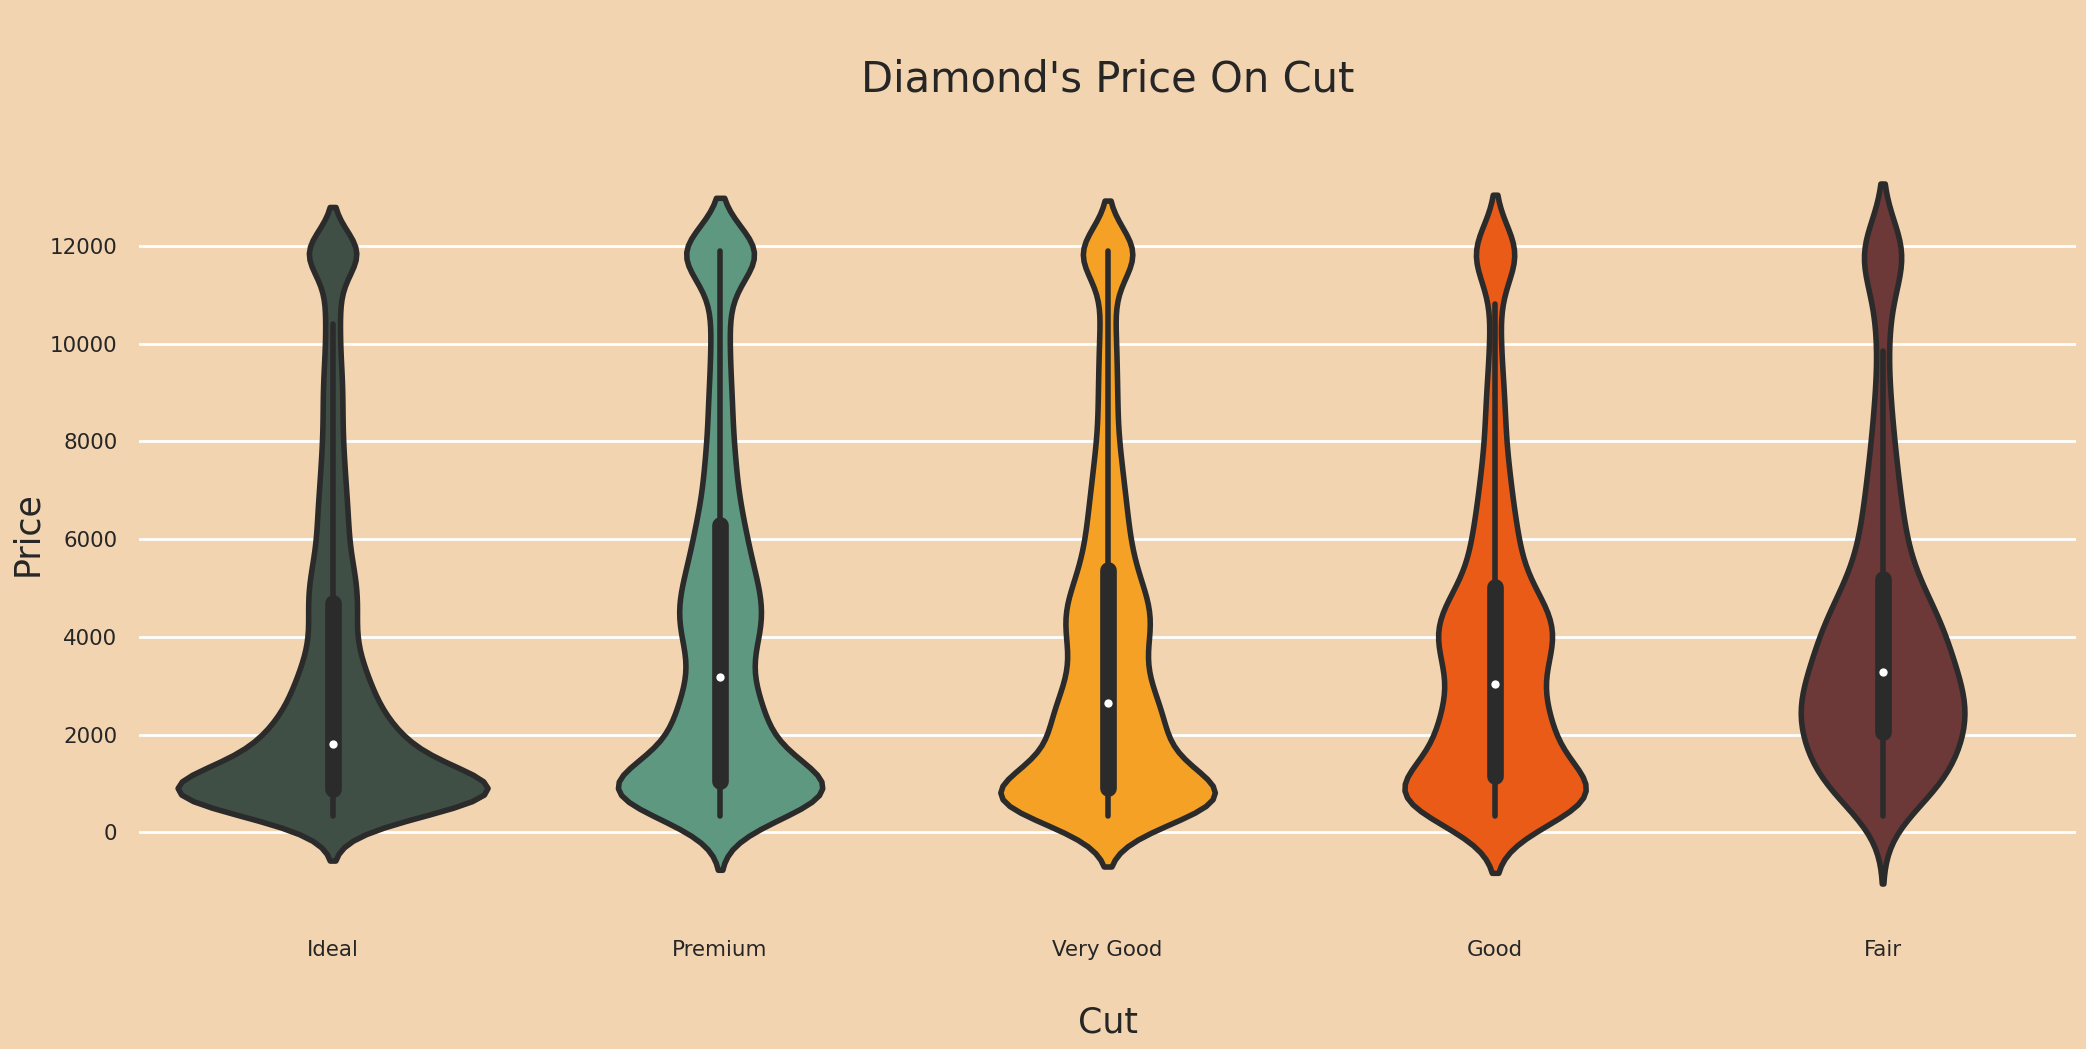

In [25]:
print("Let's have a look on the price distribution of diamond's cut :")
plt.subplots(figsize=(25, 10))

p=sns.violinplot(x=df_qual["cut"],y=df_quant["price"],order=df_qual["cut"].value_counts().index,palette=["#3f4f45","#5e9880","#f5a126","#ea5b17","#6c3938"],saturation=1,linewidth=4,edgecolor="black")
p.axes.set_title("\nDiamond's Price On Cut\n",fontsize=30)
p.axes.set_xlabel("\nCut",fontsize=25)
p.axes.set_ylabel("Price",fontsize=25)

sns.despine(left=True, bottom=True)
plt.show()

Let's have a look on the ratio of diamond's color :


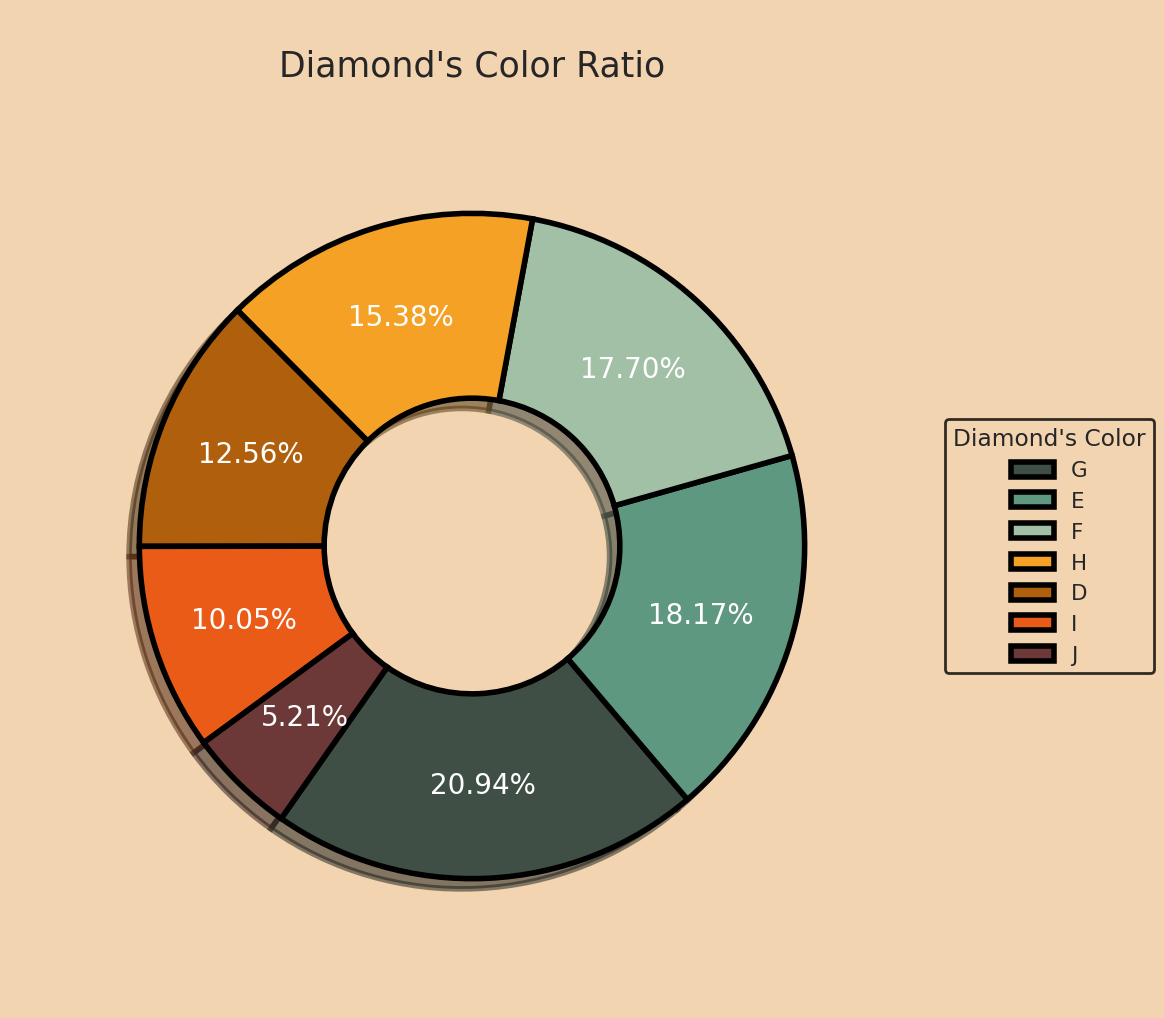

In [26]:
print(f"Let's have a look on the ratio of diamond's color :")
plt.subplots(figsize=(12, 12))

labels = "G","E","F","H","D","I","J"
size = 0.5

wedges, texts, autotexts = plt.pie([df_qual["color"].value_counts().values[0],
                                    df_qual["color"].value_counts().values[1],
                                    df_qual["color"].value_counts().values[2],
                                    df_qual["color"].value_counts().values[3],
                                    df_qual["color"].value_counts().values[4],
                                    df_qual["color"].value_counts().values[5],
                                    df_qual["color"].value_counts().values[6]],
                                    explode = (0,0,0,0,0,0,0),
                                    textprops=dict(size= 20, color= "white"),
                                    autopct="%.2f%%",
                                    pctdistance = 0.72,
                                    radius=.9,
                                    colors = ["#3f4f45","#5e9880","#a2c0a6","#f5a126","#b05f0d","#ea5b17","#6c3938"],
                                    shadow = True,
                                    wedgeprops=dict(width = size, edgecolor = "black",
                                    linewidth = 4),
                                    startangle = -125)

plt.legend(wedges, labels, title="Diamond's Color",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1), edgecolor = "black")
plt.title("\nDiamond's Color Ratio",fontsize=25)
plt.show()

Let's have a look on the diamond's color :


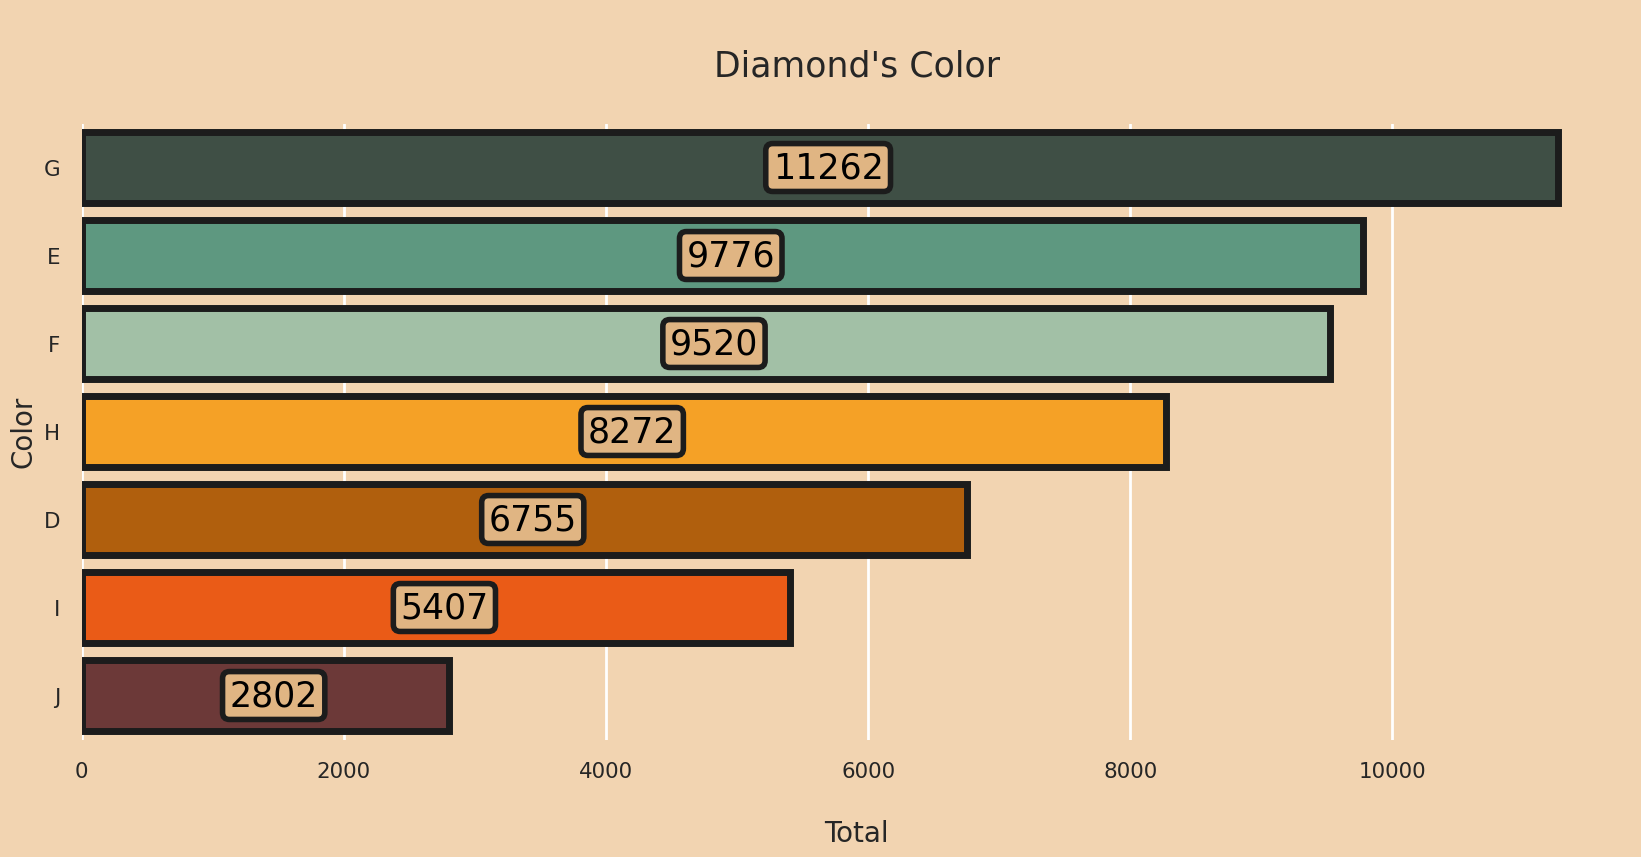

In [27]:
print("Let's have a look on the diamond's color :")
plt.subplots(figsize=(20, 8))
p=sns.countplot(y=df_qual["color"],order=df_qual["color"].value_counts().index,palette=["#3f4f45","#5e9880","#a2c0a6","#f5a126","#b05f0d","#ea5b17","#6c3938"], saturation=1, edgecolor = "#1c1c1c", linewidth = 5)
# p.axes.set_yscale("symlog")
p.axes.set_title("\nDiamond's Color\n",fontsize=25)
p.axes.set_ylabel("Color",fontsize=20)
p.axes.set_xlabel("\nTotal",fontsize=20)
p.axes.set_yticklabels(p.get_yticklabels(),rotation = 0)
for container in p.containers:
    p.bar_label(container,label_type="center",padding=6,size=25,color="black",rotation=0,
    bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": "#1c1c1c", "linewidth" : 4, "alpha": 1})


sns.despine(left=True, bottom=True)
plt.show()

Let's have a look on the price distribution of diamond's color :


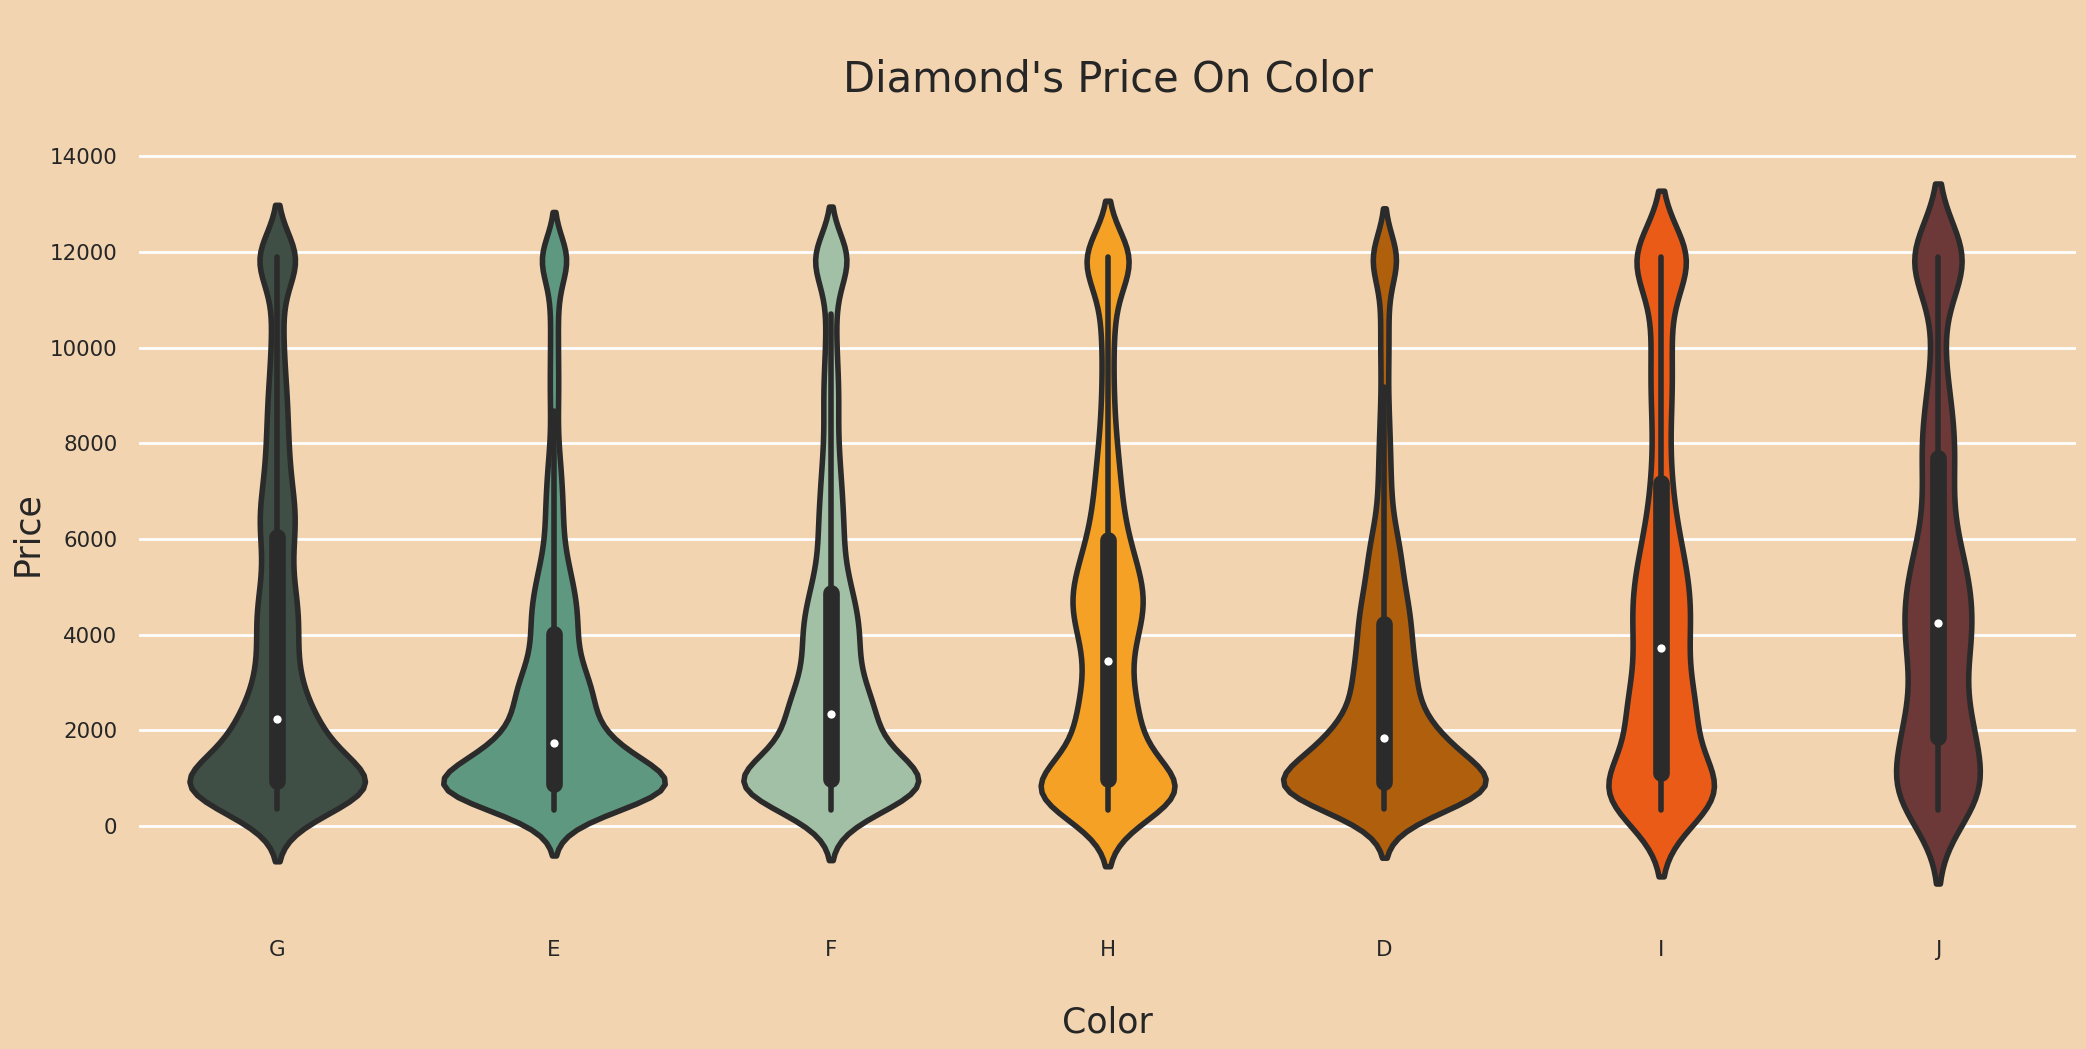

In [28]:
print("Let's have a look on the price distribution of diamond's color :")
plt.subplots(figsize=(25, 10))

p=sns.violinplot(x=df_qual["color"],y=df_quant["price"],order=df_qual["color"].value_counts().index,palette=["#3f4f45","#5e9880","#a2c0a6","#f5a126","#b05f0d","#ea5b17","#6c3938"],saturation=1,linewidth=4,edgecolor="black")
p.axes.set_title("\nDiamond's Price On Color\n",fontsize=30)
p.axes.set_xlabel("\nColor",fontsize=25)
p.axes.set_ylabel("Price",fontsize=25)

sns.despine(left=True, bottom=True)
plt.show()

Let's have a look on the ratio of diamond's clarity :


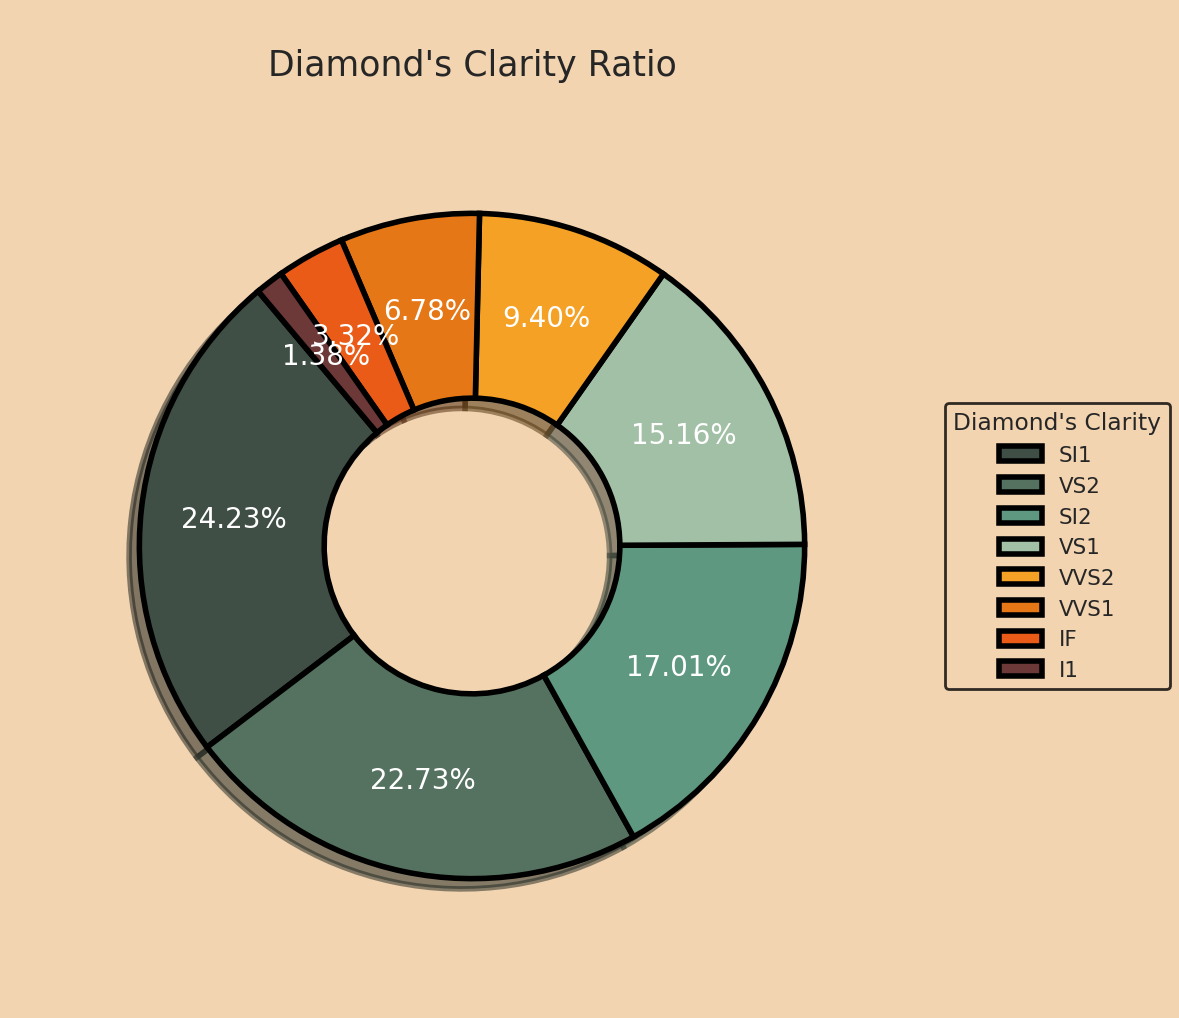

In [29]:
print(f"Let's have a look on the ratio of diamond's clarity :")
plt.subplots(figsize=(12, 12))

labels = "SI1","VS2","SI2","VS1","VVS2","VVS1","IF","I1"
size = 0.5

wedges, texts, autotexts = plt.pie([df_qual["clarity"].value_counts().values[0],
                                    df_qual["clarity"].value_counts().values[1],
                                    df_qual["clarity"].value_counts().values[2],
                                    df_qual["clarity"].value_counts().values[3],
                                    df_qual["clarity"].value_counts().values[4],
                                    df_qual["clarity"].value_counts().values[5],
                                    df_qual["clarity"].value_counts().values[6],
                                    df_qual["clarity"].value_counts().values[7]],
                                    explode = (0,0,0,0,0,0,0,0),
                                    textprops=dict(size= 20, color= "white"),
                                    autopct="%.2f%%",
                                    pctdistance = 0.72,
                                    radius=.9,
                                    colors = ["#3f4f45","#557260","#5e9880","#a2c0a6","#f5a126","#e57716","#ea5b17","#6c3938"],
                                    shadow = True,
                                    wedgeprops=dict(width = size, edgecolor = "black",
                                    linewidth = 4),
                                    startangle = -230)

plt.legend(wedges, labels, title="Diamond's Clarity",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1), edgecolor = "black")
plt.title("\nDiamond's Clarity Ratio",fontsize=25)
plt.show()

Let's have a look on the diamond's clarity :


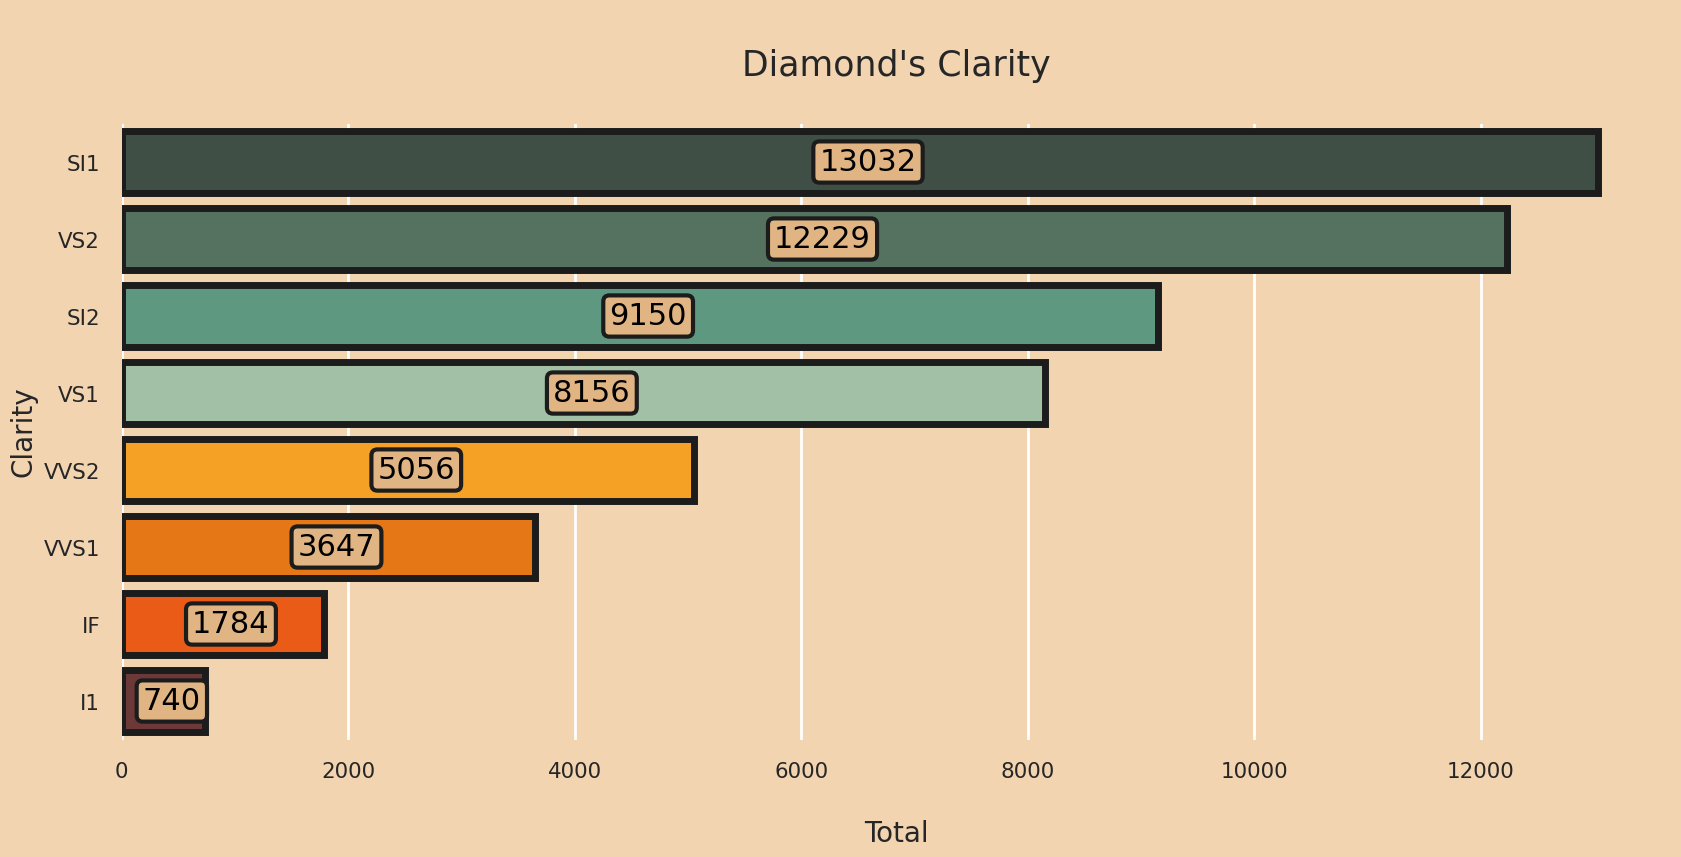

In [30]:
print("Let's have a look on the diamond's clarity :")
plt.subplots(figsize=(20, 8))
p=sns.countplot(y=df_qual["clarity"],order=df_qual["clarity"].value_counts().index,palette=["#3f4f45","#557260","#5e9880","#a2c0a6","#f5a126","#e57716","#ea5b17","#6c3938"], saturation=1, edgecolor = "#1c1c1c", linewidth = 5)
# p.axes.set_yscale("symlog")
p.axes.set_title("\nDiamond's Clarity\n",fontsize=25)
p.axes.set_ylabel("Clarity",fontsize=20)
p.axes.set_xlabel("\nTotal",fontsize=20)
p.axes.set_yticklabels(p.get_yticklabels(),rotation = 0)
for container in p.containers:
    p.bar_label(container,label_type="center",padding=6,size=22,color="black",rotation=0,
    bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": "#1c1c1c", "linewidth" : 3, "alpha": 1})


sns.despine(left=True, bottom=True)
plt.show()

Let's have a look on the price distribution of diamond's clarity :


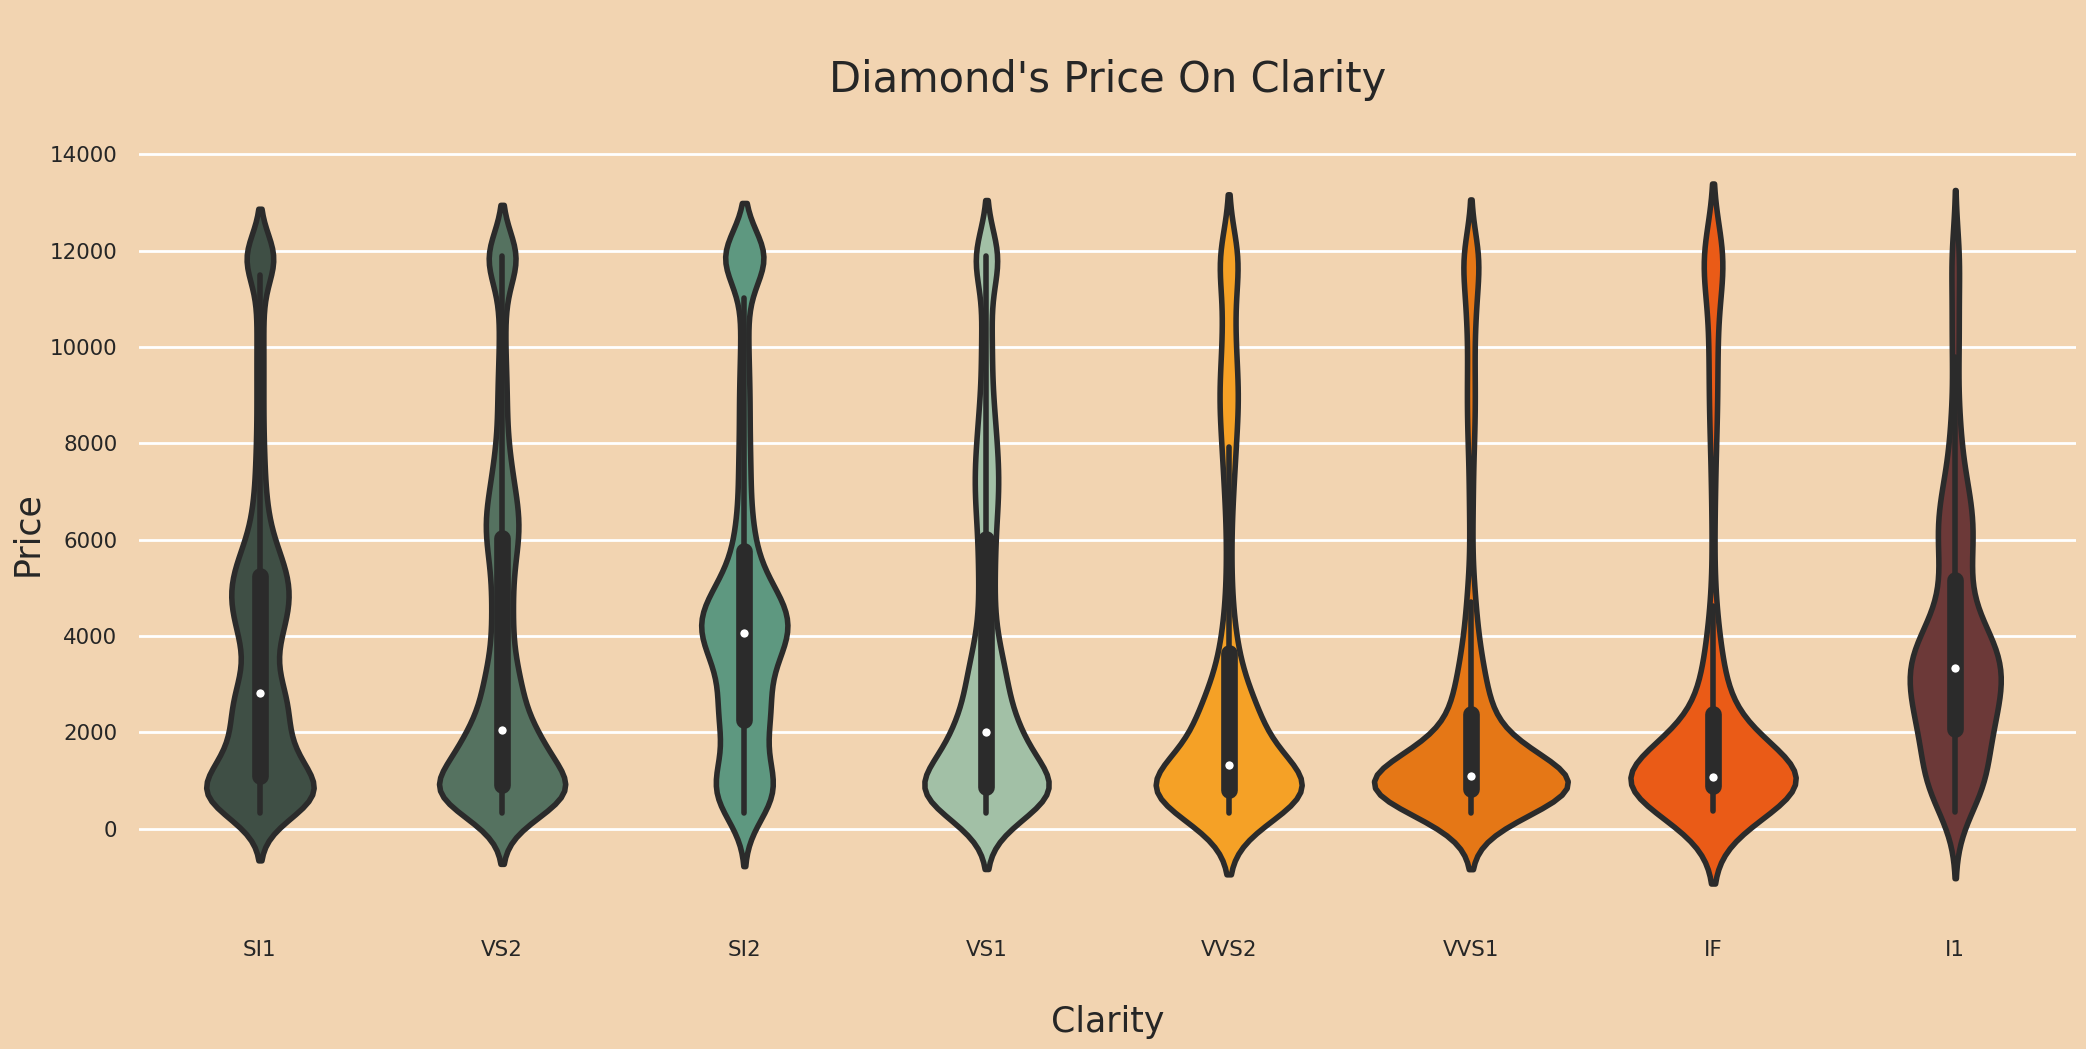

In [31]:
print("Let's have a look on the price distribution of diamond's clarity :")
plt.subplots(figsize=(25, 10))

p=sns.violinplot(x=df_qual["clarity"],y=df_quant["price"],order=df_qual["clarity"].value_counts().index,palette=["#3f4f45","#557260","#5e9880","#a2c0a6","#f5a126","#e57716","#ea5b17","#6c3938"],saturation=1,linewidth=4,edgecolor="black")
p.axes.set_title("\nDiamond's Price On Clarity\n",fontsize=30)
p.axes.set_xlabel("\nClarity",fontsize=25)
p.axes.set_ylabel("Price",fontsize=25)

sns.despine(left=True, bottom=True)
plt.show()

Let's have a look on the distribution of weight in carat :


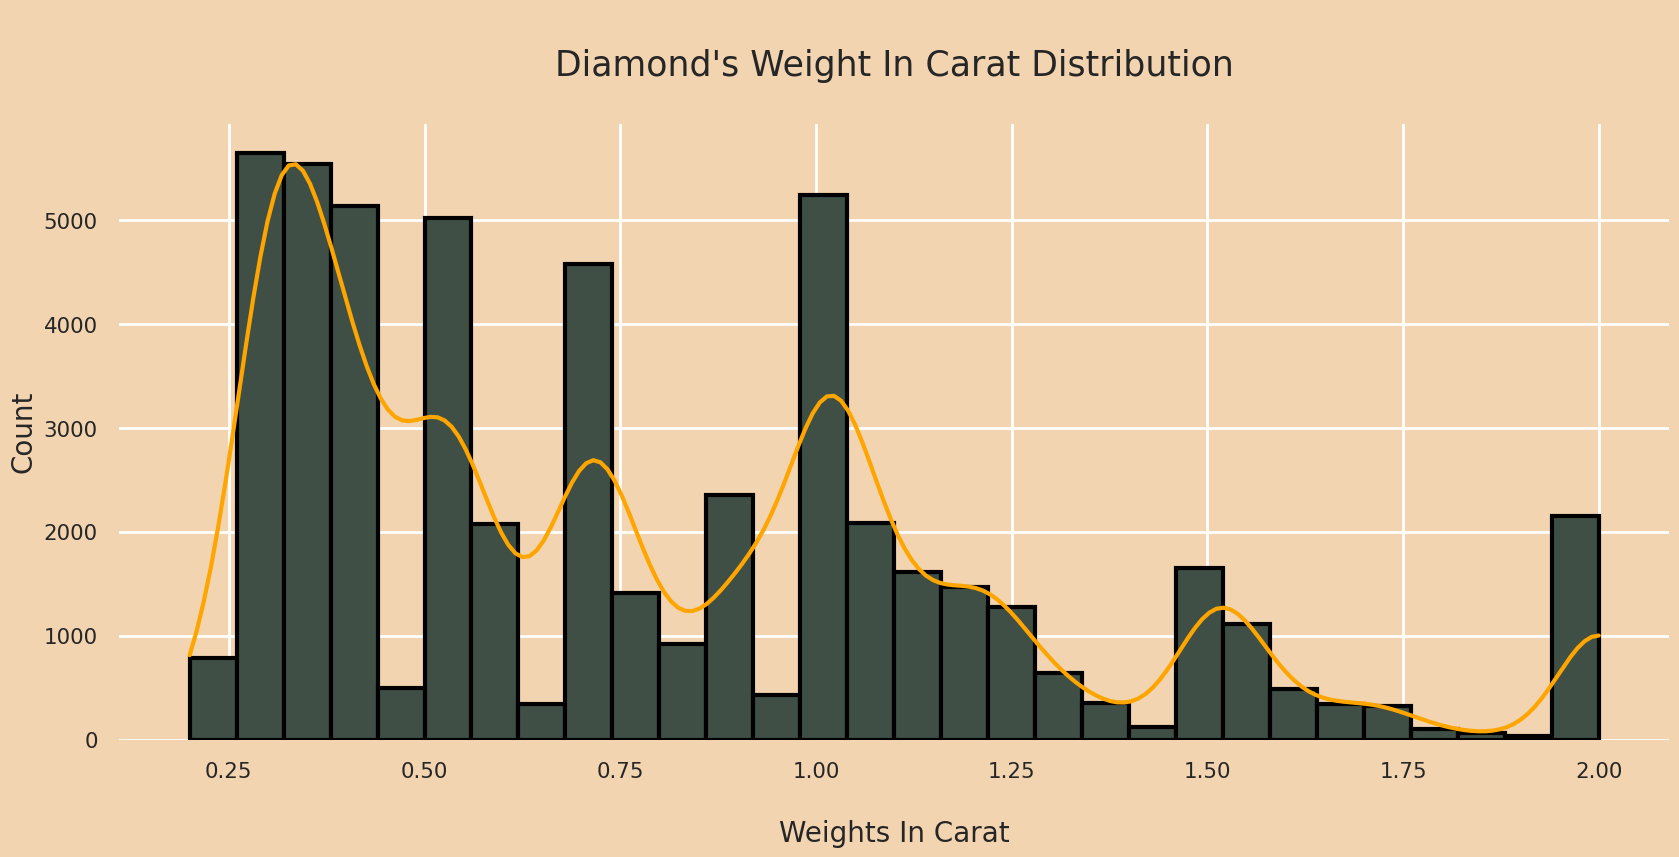

In [32]:
print(f"Let's have a look on the distribution of weight in carat :")
plt.subplots(figsize=(20, 8))
p = sns.histplot(df_quant["carat"],color="#3f4f45",kde=True,bins=30,alpha=1,fill=True,edgecolor="black",linewidth=3)
p.axes.lines[0].set_color("orange")
p.axes.set_title("\nDiamond's Weight In Carat Distribution\n",fontsize=25)
plt.ylabel("Count",fontsize=20)
plt.xlabel("\nWeights In Carat",fontsize=20)
# plt.yscale("linear")
sns.despine(left=True, bottom=True)

plt.show()

Let's have a look on the price distribution of weights in carat :


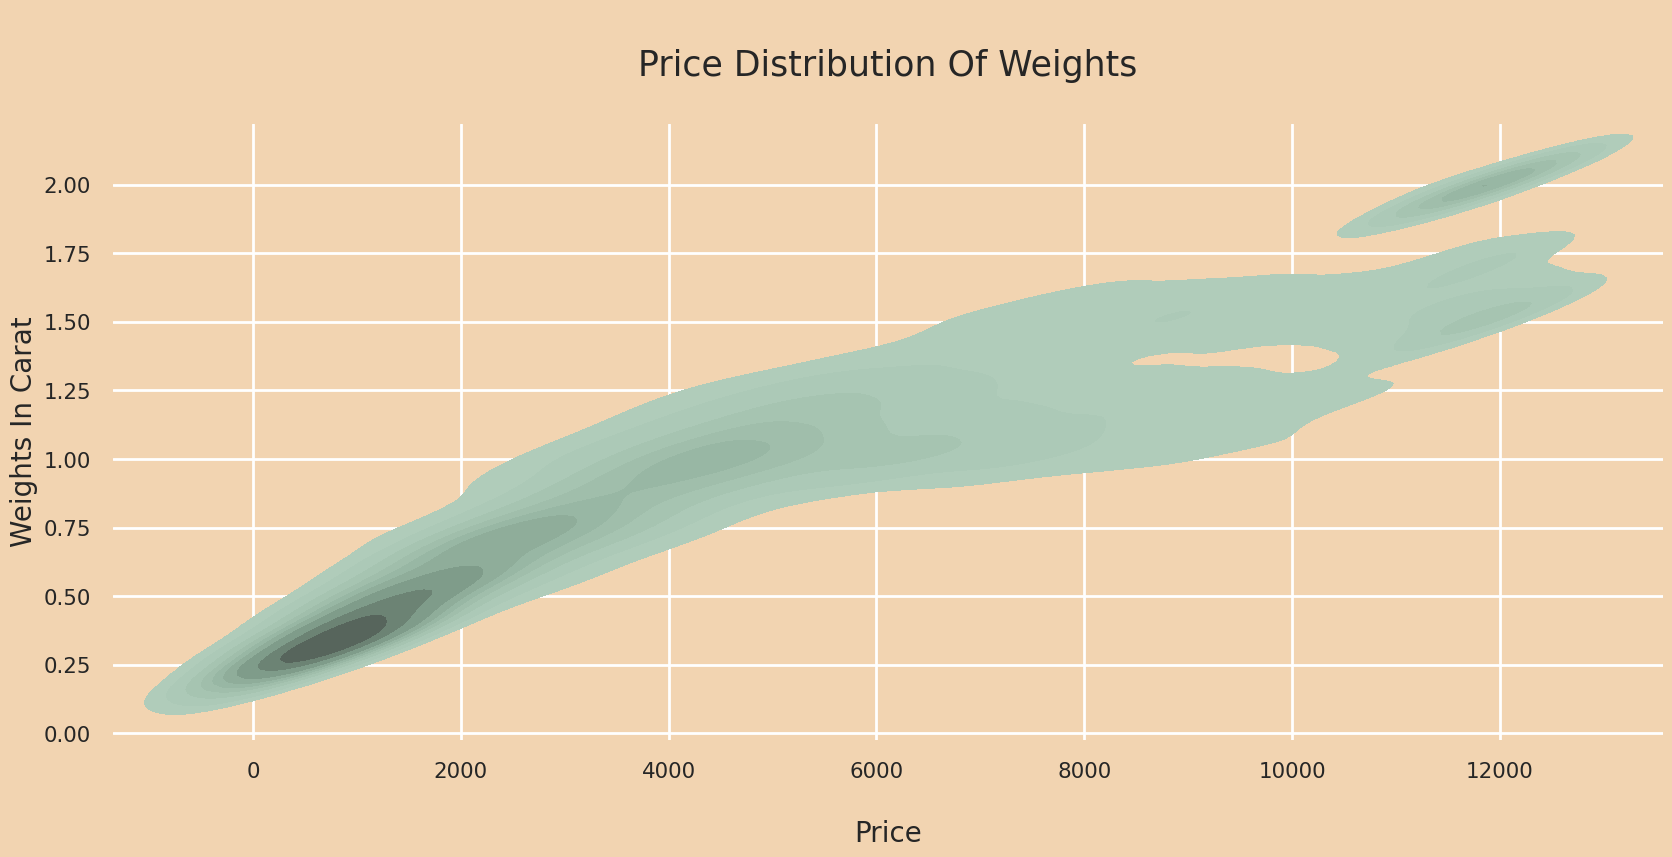

In [33]:
print("Let's have a look on the price distribution of weights in carat :")

_, axes = plt.subplots(figsize=(20,8))
sns.kdeplot(y=df_quant["carat"], x=df_quant["price"],edgecolor="#1c1c1c",fill=True, kind="kde",shade=True,height=10,color="#3f4f45")
axes.set_title("\nPrice Distribution Of Weights\n",fontsize=25)
axes.set_xlabel("\nPrice",fontsize=20)
axes.set_ylabel("Weights In Carat",fontsize=20)

sns.despine(left=True, bottom=True)
plt.show()

Let's have a look on the distribution of depth percentage :


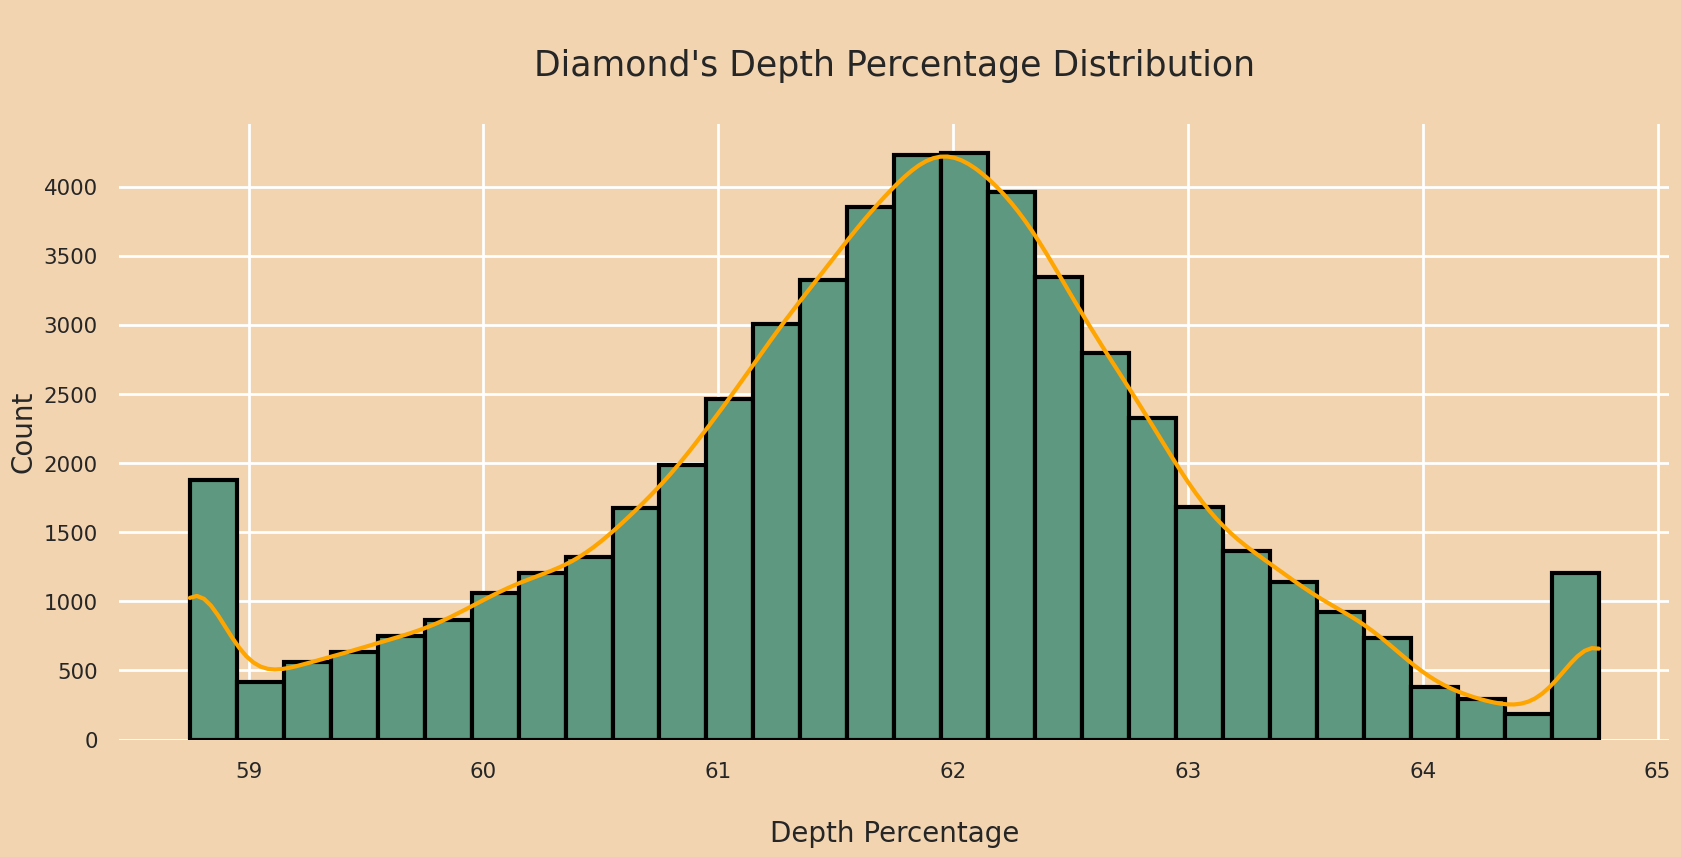

In [34]:
print(f"Let's have a look on the distribution of depth percentage :")
plt.subplots(figsize=(20, 8))
p = sns.histplot(df_quant["depth"],color="#5e9880",kde=True,bins=30,alpha=1,fill=True,edgecolor="black",linewidth=3)
p.axes.lines[0].set_color("orange")
p.axes.set_title("\nDiamond's Depth Percentage Distribution\n",fontsize=25)
plt.ylabel("Count",fontsize=20)
plt.xlabel("\nDepth Percentage",fontsize=20)
# plt.yscale("linear")
sns.despine(left=True, bottom=True)

plt.show()

Let's have a look on the price distribution of depth percentage :


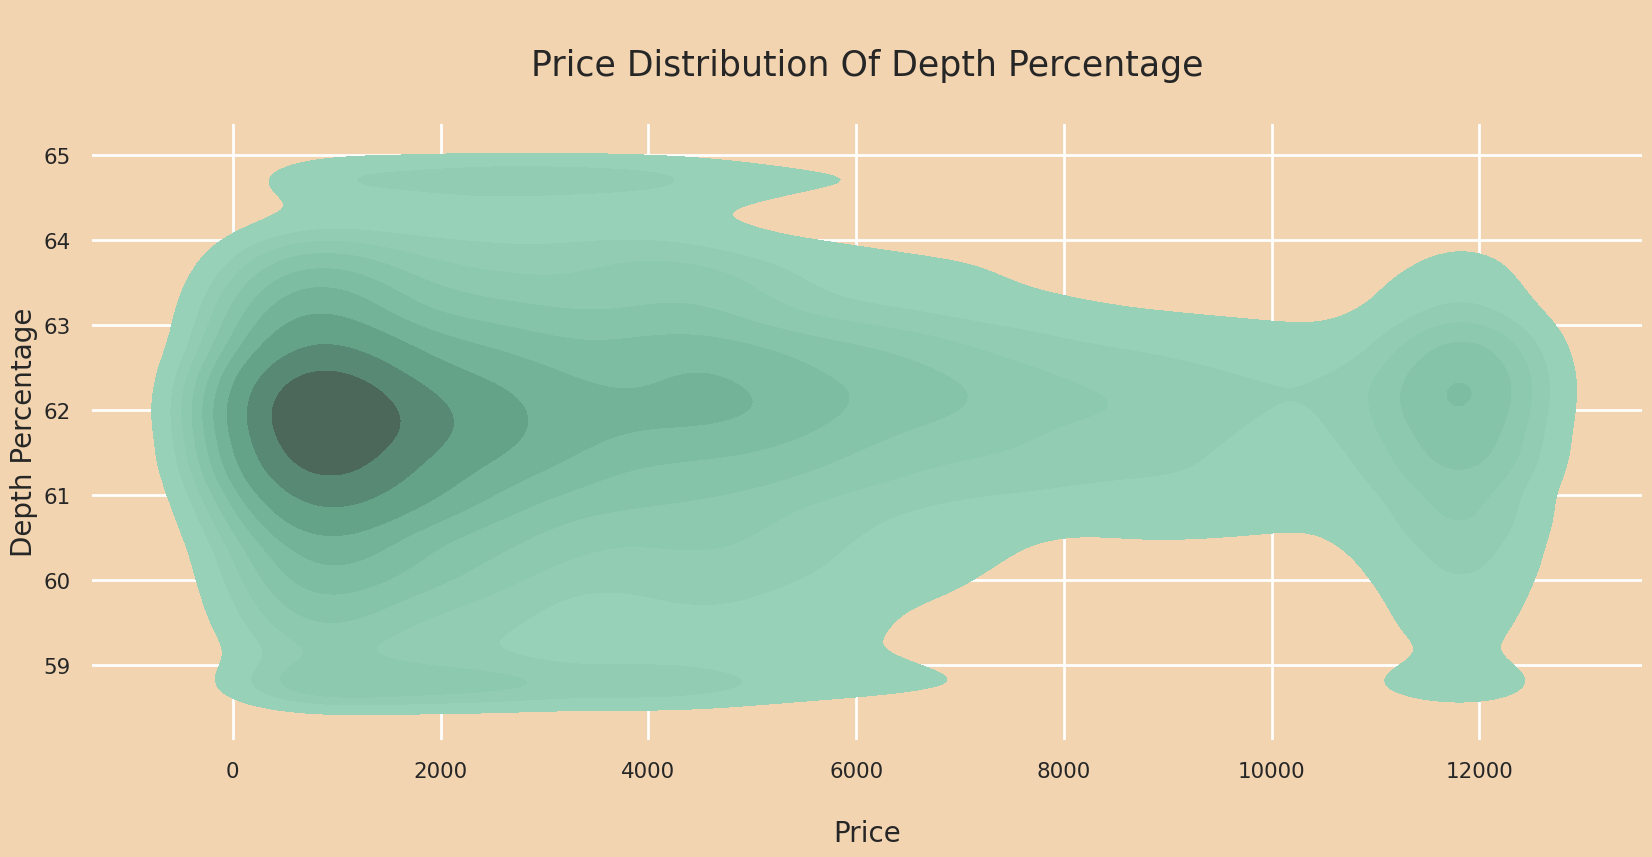

In [35]:
print("Let's have a look on the price distribution of depth percentage :")

_, axes = plt.subplots(figsize=(20,8))
sns.kdeplot(y=df_quant["depth"], x=df_quant["price"],edgecolor="#1c1c1c",fill=True, kind="kde",shade=True,height=10,color="#5e9880")
axes.set_title("\nPrice Distribution Of Depth Percentage\n",fontsize=25)
axes.set_xlabel("\nPrice",fontsize=20)
axes.set_ylabel("Depth Percentage",fontsize=20)

sns.despine(left=True, bottom=True)
plt.show()

Let's have a look on the distribution of diamond's table :


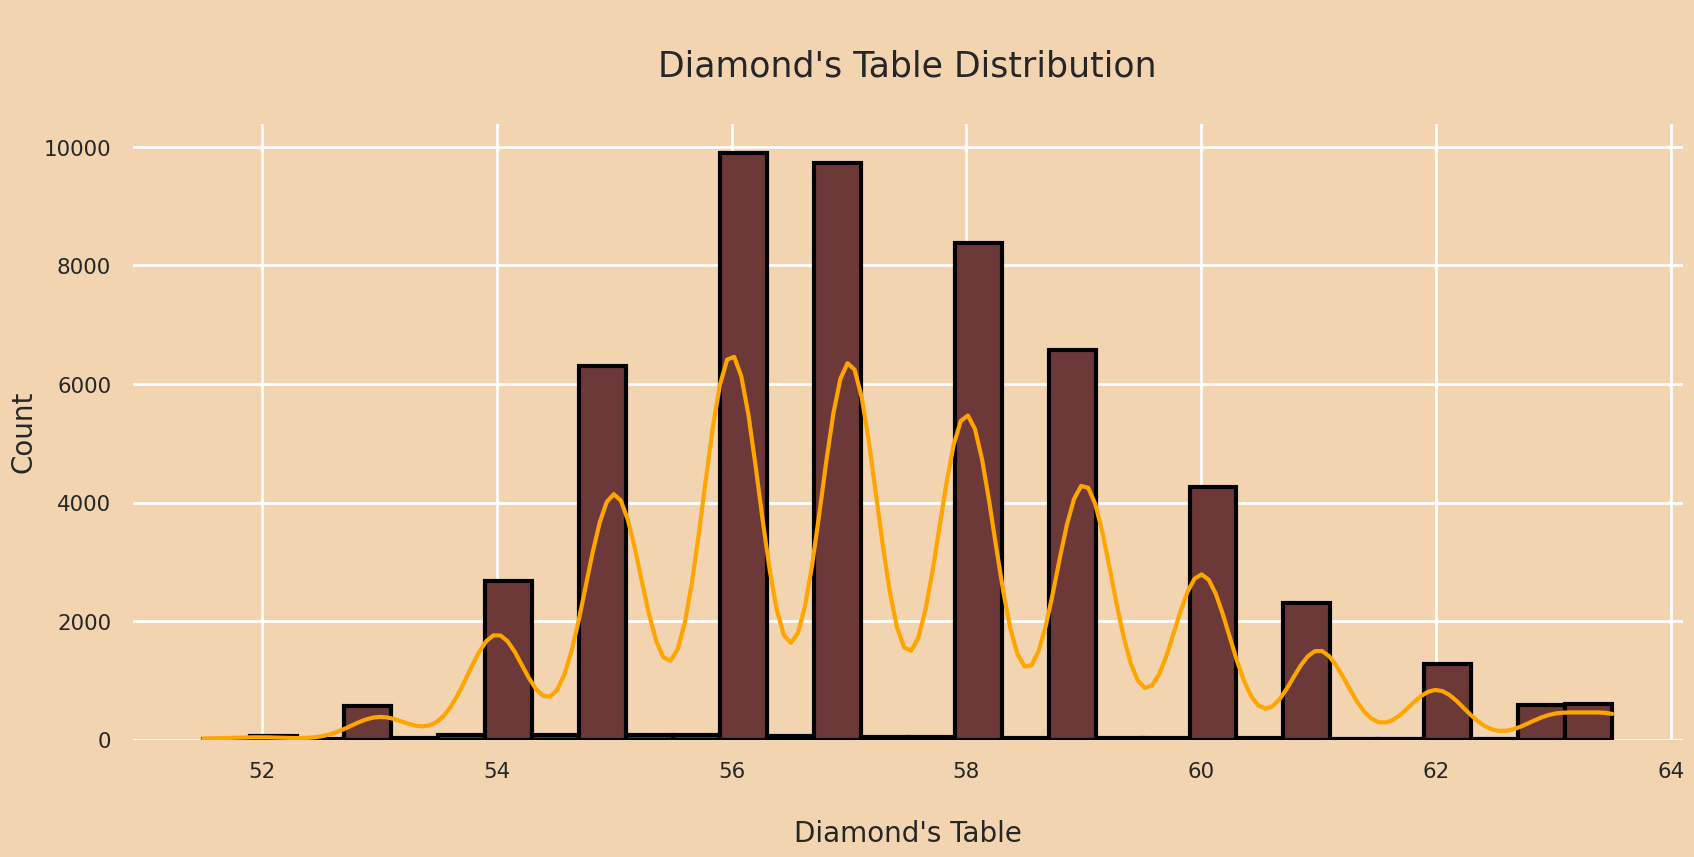

In [36]:
print(f"Let's have a look on the distribution of diamond's table :")
plt.subplots(figsize=(20, 8))
p = sns.histplot(df_quant["table"],color="#6c3938",kde=True,bins=30,alpha=1,fill=True,edgecolor="black",linewidth=3)
p.axes.lines[0].set_color("orange")
p.axes.set_title("\nDiamond's Table Distribution\n",fontsize=25)
plt.ylabel("Count",fontsize=20)
plt.xlabel("\nDiamond's Table",fontsize=20)
# plt.yscale("linear")
sns.despine(left=True, bottom=True)

plt.show()

Let's have a look on the price distribution of diamond's table :


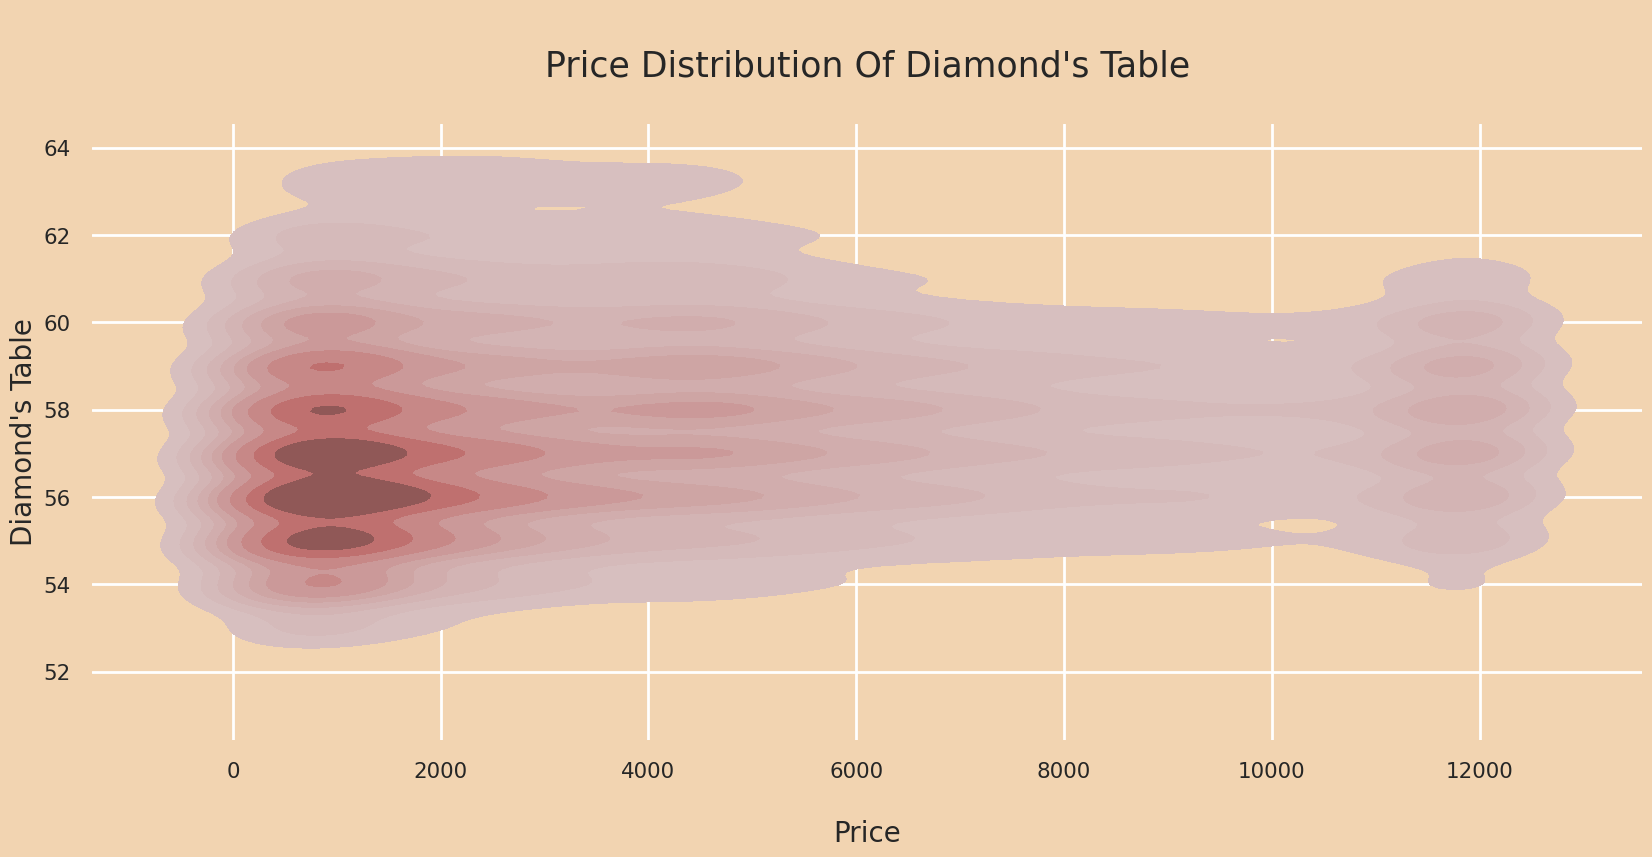

In [37]:
print("Let's have a look on the price distribution of diamond's table :")

_, axes = plt.subplots(figsize=(20,8))
sns.kdeplot(y=df_quant["table"], x=df_quant["price"],edgecolor="#1c1c1c",fill=True, kind="kde",shade=True,height=10,color="#6c3938")
axes.set_title("\nPrice Distribution Of Diamond's Table\n",fontsize=25)
axes.set_xlabel("\nPrice",fontsize=20)
axes.set_ylabel("Diamond's Table",fontsize=20)

sns.despine(left=True, bottom=True)
plt.show()

## Statistical Hypothesis Testing

In [39]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [40]:
data = df[['cut', 'price']]

In [41]:
ideal = data[data['cut']=='Ideal']['price']
premium = data[data['cut']=='Premium']['price']
very_good = data[data['cut']=='Very Good']['price']
good = data[data['cut']=='Good']['price']
fair = data[data['cut']=='Fair']['price']

In [42]:
fvalue, pvalue = stats.f_oneway(ideal, premium, very_good, good, fair)
print('%.3f' % pvalue)

nan


**If p-value < 0.05, we have to reject H0 hypothesis. It means that at least one group is different. We have to do Tukey test.**

In [43]:
# Tukey test
tukey = pairwise_tukeyhsd(endog=data['price'],
                          groups=data['cut'],
                          alpha=0.05)

print(tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff p-adj    lower      upper   reject
----------------------------------------------------------
     0      1 -380.1233 0.0001  -614.7108 -145.5359   True
     0      2 -814.9227    0.0 -1026.0241 -603.8213   True
     0      3   83.1146 0.8301  -132.0608  298.2899  False
     0      4 -367.9761    0.0  -584.7044 -151.2478   True
     1      2 -434.7993    0.0  -563.7832 -305.8155   True
     1      3  463.2379    0.0   327.6891  598.7868   True
     1      4   12.1472 0.9993  -125.8536   150.148  False
     2      3  898.0372    0.0   809.1215   986.953   True
     2      4  446.9466    0.0   354.3359  539.5573   True
     3      4 -451.0907    0.0  -552.6455 -349.5358   True
----------------------------------------------------------


In [44]:
hypotesis_testing(df, 'price', 'color')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     1755.
Date:                Tue, 01 Aug 2023   Prob (F-statistic):               0.00
Time:                        20:44:01   Log-Likelihood:            -5.0628e+05
No. Observations:               53794   AIC:                         1.013e+06
Df Residuals:                   53792   BIC:                         1.013e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2275.2969     23.262     97.810      0.0

In [45]:
tukey = pairwise_tukeyhsd(endog=df['price'],
                          groups=df['color'],
                          alpha=0.05)

print(tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
     0      1  -86.1072 0.5202 -224.0275   51.8131  False
     0      2  438.5286    0.0  299.8526  577.2046   True
     0      3  645.2472    0.0  511.0965  779.3978   True
     0      4 1039.0472    0.0  896.0952 1181.9992   True
     0      5 1438.9098    0.0 1279.8415 1597.9781   True
     0      6 1706.5527    0.0 1510.6745 1902.4308   True
     1      2  524.6358    0.0  399.1177  650.1539   True
     1      3  731.3544    0.0  610.8547   851.854   True
     1      4 1125.1544    0.0  994.9275 1255.3813   True
     1      5  1525.017    0.0 1377.2791 1672.7549   True
     1      6 1792.6599    0.0 1605.8658 1979.4539   True
     2      3  206.7186    0.0   85.3547  328.0824   True
     2      4  600.5186    0.0  469.4916  731.5455   True
     2      5 1000.3812    0.0  851.9376 1148.8248   True
     2      6 

In [46]:
hypotesis_testing(df, 'price', 'clarity')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     376.2
Date:                Tue, 01 Aug 2023   Prob (F-statistic):           1.65e-83
Time:                        20:44:02   Log-Likelihood:            -5.0696e+05
No. Observations:               53794   AIC:                         1.014e+06
Df Residuals:                   53792   BIC:                         1.014e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3647.3923     31.499    115.794      0.0

In [47]:
tukey = pairwise_tukeyhsd(endog = df['price'],
                          groups = df['clarity'],
                          alpha = 0.05)

print(tukey)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
     0      1 -1131.8798    0.0 -1523.6998  -740.0598   True
     0      2   -79.2488 0.9968  -417.8841   259.3866  False
     0      3   742.9826    0.0   400.5091   1085.456   True
     0      4  -250.3034 0.3484  -594.3348     93.728  False
     0      5   -180.414 0.7433  -519.6463   158.8182  False
     0      6 -1359.9126    0.0  -1721.202  -998.6232   True
     0      7  -721.9521    0.0 -1074.6477  -369.2566   True
     1      2   1052.631    0.0    826.418  1278.8441   True
     1      3  1874.8624    0.0  1642.9432  2106.7816   True
     1      4   881.5764    0.0   647.3627  1115.7901   True
     1      5   951.4658    0.0   724.3602  1178.5714   True
     1      6  -228.0328 0.1319  -486.9315    30.8658  False
     1      7   409.9277    0.0   163.1634   656.6919   True
     2      3   822.2314

## Data Engineering

In [48]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,3,2,1,3,83,30,0,20,26,24
1,1,3,1,2,66,90,0,14,12,12
2,3,1,1,4,37,115,1,30,35,12
3,9,3,5,5,92,60,2,45,51,44
4,11,1,6,3,101,60,3,59,63,56


In [49]:
df.shape

(53794, 10)

In [51]:
# Removing the datapoints having min 0 value in either x, y or z features
df = df.drop(df[df["x"]==0].index)
df = df.drop(df[df["y"]==0].index)
df = df.drop(df[df["z"]==0].index)
df.shape

(53775, 10)

In [52]:
# Making a copy to keep original data in its form intact
data1 = df.copy()

# Applying label encoder to columns with categorical data
columns = ['cut','color','clarity']
label_encoder = LabelEncoder()
for col in columns:
    data1[col] = label_encoder.fit_transform(data1[col])
data1.describe()

,carat,cut,color,clarity,depth,table,price,x,y,z
count,53775.000,53775.000,53775.000,53775.000,53775.000,53775.000,53775.000,53775.000,53775.000,53775.000
mean,59.718,2.554,2.594,3.836,85.487,54.377,3088.996,198.132,201.331,134.937
std,47.128,1.028,1.701,1.725,14.185,21.517,3005.671,111.772,110.983,69.062
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000
25%,20.000,2.000,1.000,2.000,78.000,40.000,606.000,96.000,100.000,72.000
50%,50.000,2.000,3.000,4.000,86.000,50.000,1955.000,195.000,199.000,134.000
75%,84.000,3.000,4.000,5.000,93.000,70.000,4720.000,279.000,282.000,184.000
max,272.000,4.000,6.000,7.000,183.000,126.000,11601.000,553.000,551.000,374.000


<Axes: >

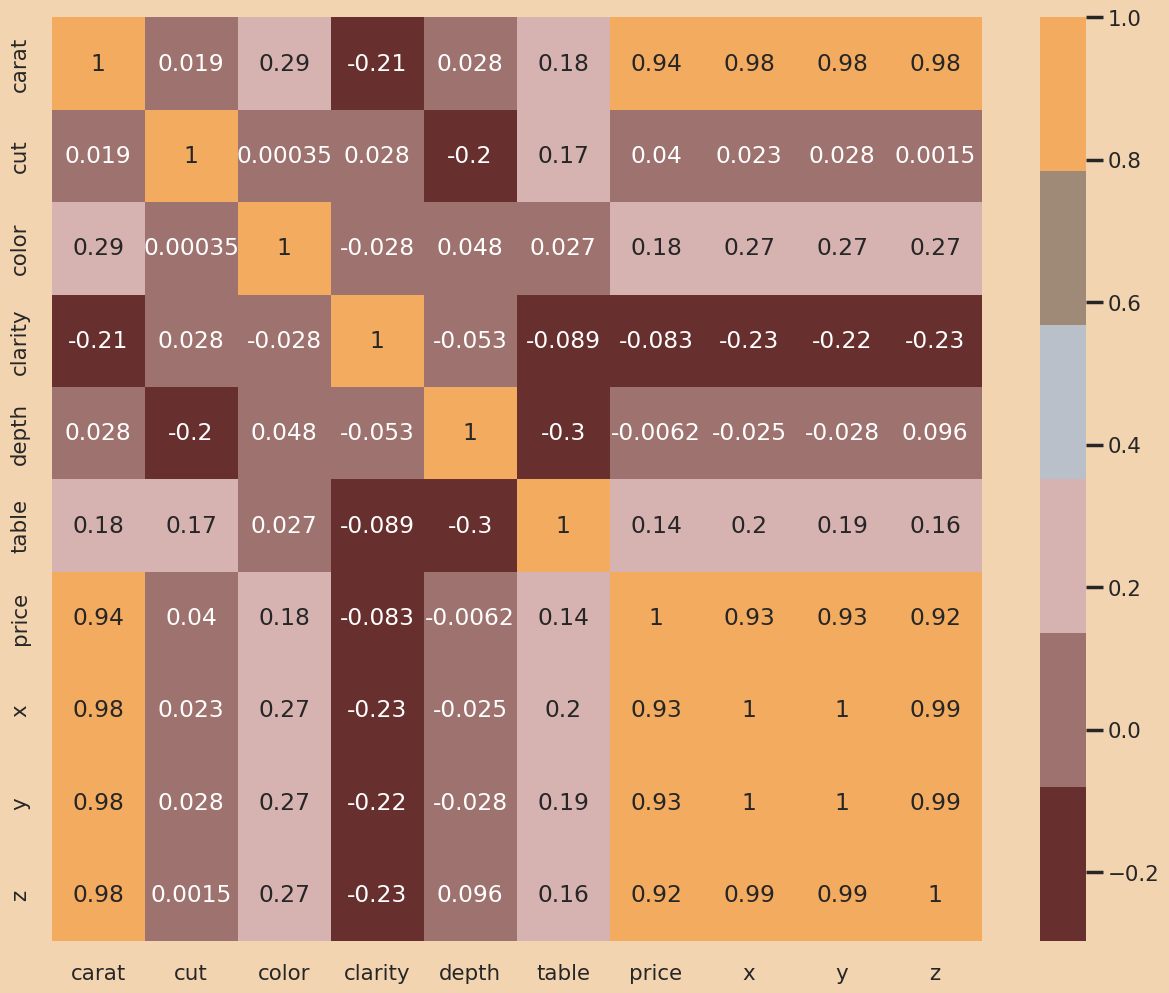

In [53]:
# Examining correlation matrix using heatmap
cmap = sns.diverging_palette(205, 133, 63, as_cmap=True)
cols = (["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
corrmat= data1.corr()
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corrmat,cmap=cols,annot=True)

## Model Creation & Performance Evaluation

In [54]:
# Defining the independent and dependent variables
X= data1.drop(["price"],axis =1)
y= data1["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=25)

In [58]:
# Building pipelins of standard scaler and model for varios regressors.

pipeline_lr=Pipeline([("scalar1",StandardScaler()),
                     ("lr",LinearRegression())])

pipeline_lasso=Pipeline([("scalar2", StandardScaler()),
                      ("lasso",Lasso())])

pipeline_dt=Pipeline([("scalar3",StandardScaler()),
                     ("dt",DecisionTreeRegressor())])

pipeline_rf=Pipeline([("scalar4",StandardScaler()),
                     ("rf",RandomForestRegressor())])


pipeline_kn=Pipeline([("scalar5",StandardScaler()),
                     ("kn",KNeighborsRegressor())])


pipeline_xgb=Pipeline([("scalar6",StandardScaler()),
                     ("xgb",XGBRegressor())])

# List of all the pipelines
pipelines = [pipeline_lr, pipeline_lasso, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb]

# Dictionary of pipelines and model types for ease of reference
pipeline_dict = {0: "LinearRegression", 1: "Lasso", 2: "DecisionTree", 3: "RandomForest",4: "KNeighbors", 5: "XGBRegressor"}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [59]:
cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_root_mean_squared_error", cv=12)
    cv_results_rms.append(cv_score)
    print("%s: %f " % (pipeline_dict[i], -1 * cv_score.mean()))

LinearRegression: 876.913182 
Lasso: 877.776150 
DecisionTree: 451.986615 
RandomForest: 329.084803 
KNeighbors: 503.124883 
XGBRegressor: 321.328362 


In [60]:
# Model prediction on test data with XGBClassifier which gave us the least RMSE
pred = pipeline_xgb.predict(X_test)
print("R^2:",metrics.r2_score(y_test, pred))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

R^2: 0.9891748277330537
Adjusted R^2: 0.9891657605808524


## Thank you so much. Sincerely, Eslam Fouad.